# ANÁLISIS PREDICTIVO DEL ESTADO DE LOS EMBALSES Y ESTUDIO DE SU EVOLUCIÓN HISTÓRICA. MODELO DE PREDICCIÓN DE VOLUMENES FUTUROS.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.Análisis exploratorio inicial

* Cargamos la información extraida del notebook de **Análisis Exploratorio de Datos**. En concreto vamos a cargar el .CSV que contiene todos los datos de evolución histórica de los embalses **entre 1995 y 2024**.

In [3]:
evolucion_embalses_1995_2024_path = "/content/drive/MyDrive/Colab Notebooks/CEI_project/processed_data/especificas/lineas.csv"
df = pd.read_csv(evolucion_embalses_1995_2024_path)

In [4]:
df.head()

nombre_embalse demarcacion_hidrografica  capacidad_total       fecha  \
0     Albarellos               Miño - Sil             91.0  1995-01-03   
1     Albarellos               Miño - Sil             91.0  1995-01-10   
2     Albarellos               Miño - Sil             91.0  1995-01-17   
3     Albarellos               Miño - Sil             91.0  1995-01-24   
4     Albarellos               Miño - Sil             91.0  1995-01-31   

   volumen_actual  porcentaje_actual   año  trimestre  mes  semana_año  \
0            56.0              61.54  1995          1    1           1   
1            49.0              53.85  1995          1    1           2   
2            41.0              45.05  1995          1    1           3   
3            47.0              51.65  1995          1    1           4   
4            58.0              63.74  1995          1    1           5   

           embalse_fecha  
0  Albarellos 1995-01-03  
1  Albarellos 1995-01-10  
2  Albarellos 1995-01-17  
3  Albarellos 1995-01-24  
4  Albarellos 1995-01-31

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541474 entries, 0 to 541473
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   nombre_embalse            541474 non-null  object 
 1   demarcacion_hidrografica  541474 non-null  object 
 2   capacidad_total           541474 non-null  float64
 3   fecha                     541474 non-null  object 
 4   volumen_actual            541474 non-null  float64
 5   porcentaje_actual         538417 non-null  float64
 6   año                       541474 non-null  int64  
 7   trimestre                 541474 non-null  int64  
 8   mes                       541474 non-null  int64  
 9   semana_año                541474 non-null  int64  
 10  embalse_fecha             541474 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 45.4+ MB


In [6]:
df["fecha"] = pd.to_datetime(df["fecha"], format="%Y-%m-%d")

* Usamos la función `replace` junto con una regular expresion para eliminar los caracteres especiales de las demarcaciones y evitar posibles errores

In [7]:
df["demarcacion_hidrografica"].replace({"[-, ]": ""}, regex=True, inplace = True)

* En caso de que quisieramos realizar un modelo predictivo del volumen de todos los embalses tendríamos que generar un df con la información de cada embalse y realizar el modelo de cada uno de ellos. Para que la tarea sea menos exigente a nivel computacional, **se ha decidido realizar la predicción de volúmenes por demarcación hidrográfica**, ya que en este caso sólo existen 16, por lo que reducimos enormemente la exigencia computacional.

In [8]:
df_demarcaciones = df.groupby(["demarcacion_hidrografica", "fecha"])["volumen_actual"].sum().reset_index()

In [9]:
df_demarcaciones.head()

demarcacion_hidrografica      fecha  volumen_actual
0     CantábricoOccidental 1995-01-03           419.0
1     CantábricoOccidental 1995-01-10           445.0
2     CantábricoOccidental 1995-01-17           441.0
3     CantábricoOccidental 1995-01-24           434.0
4     CantábricoOccidental 1995-01-31           473.0

In [10]:
df_demarcaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24208 entries, 0 to 24207
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   demarcacion_hidrografica  24208 non-null  object        
 1   fecha                     24208 non-null  datetime64[ns]
 2   volumen_actual            24208 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 567.5+ KB


* Dividimos la variable fecha en cuatro nuevas variables correspondientes a el año, trimestre, mes y semana. Ya que como veremos a la hora de entrenar el modelo, estos atributos pueden ser muy útiles.

In [11]:
df_demarcaciones["año"] = df_demarcaciones["fecha"].dt.year
df_demarcaciones['trimestre'] = df_demarcaciones['fecha'].dt.quarter
df_demarcaciones["mes"] = df_demarcaciones["fecha"].dt.month
df_demarcaciones['semana_año'] = df_demarcaciones['fecha'].dt.isocalendar().week

In [12]:
def separar_demarcaciones_crear_dfs(df):
    demarcaciones = df_demarcaciones["demarcacion_hidrografica"].unique()
    for demarcacion in demarcaciones:
        # Crear un DataFrame temporal solo con las columnas necesarias
        temp_df = df_demarcaciones[df_demarcaciones["demarcacion_hidrografica"] == demarcacion][['fecha', 'volumen_actual', 'año', 'trimestre', 'mes', 'semana_año']].reset_index(drop=True)
        # Asignar el DataFrame temporal a una variable global
        globals()[f'df_{demarcacion}'] = temp_df

In [13]:
separar_demarcaciones_crear_dfs(df_demarcaciones)

* Generamos el nombre de todos los df que hemos creado:

In [14]:
demarcaciones = df_demarcaciones["demarcacion_hidrografica"].unique()
for demarcacion in demarcaciones:
    print(f"df_{demarcacion}")

df_CantábricoOccidental
df_CantábricoOriental
df_CuencaMediterráneaAndaluza
df_CuencasInternasdeCataluña
df_CuencasInternasdelPaísVasco
df_Duero
df_Ebro
df_GaliciaCosta
df_GuadaleteBarbate
df_Guadalquivir
df_Guadiana
df_Júcar
df_MiñoSil
df_Segura
df_Tajo
df_TintoOdielyPiedras


In [15]:
df_MiñoSil.head(10) #Visualizamos uno de los df de las demarcaciones para comprobar que se ha creado correctamente

fecha  volumen_actual   año  trimestre  mes  semana_año
0 1995-01-03          1835.0  1995          1    1           1
1 1995-01-10          1890.0  1995          1    1           2
2 1995-01-17          1865.0  1995          1    1           3
3 1995-01-24          1966.0  1995          1    1           4
4 1995-01-31          2218.0  1995          1    1           5
5 1995-02-07          2262.0  1995          1    2           6
6 1995-02-14          2248.0  1995          1    2           7
7 1995-02-21          2513.0  1995          1    2           8
8 1995-02-28          2551.0  1995          1    2           9
9 1995-03-07          2596.0  1995          1    3          10

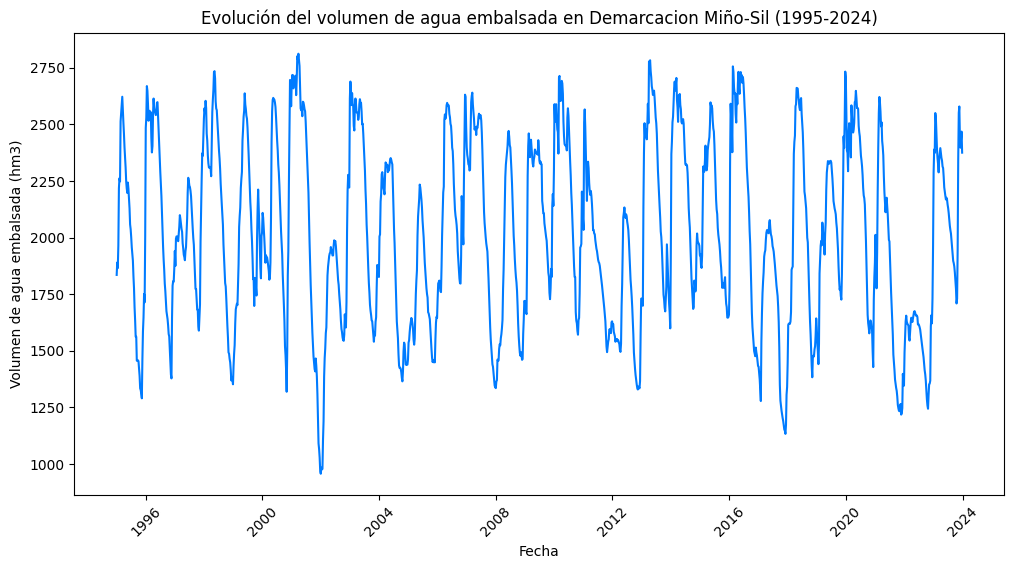

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_MiñoSil, x="fecha", y="volumen_actual", color="#007bff")

plt.xticks(rotation=45)
plt.title('Evolución del volumen de agua embalsada en Demarcacion Miño-Sil (1995-2024)')
plt.xlabel('Fecha')
plt.ylabel('Volumen de agua embalsada (hm3)')

plt.show()

* Vamos a generar una función que nos permita visualizar la evolución del volumen de agua embalsada de cada una de las demarcaciones hidrográficas que hemos definido anteriormente:

In [17]:
demarcaciones = [
    'CantábricoOccidental',
    'CantábricoOriental',
    'CuencaMediterráneaAndaluza',
    'CuencasInternasdeCataluña',
    'CuencasInternasdelPaísVasco',
    'Duero',
    'Ebro',
    'GaliciaCosta',
    'GuadaleteBarbate',
    'Guadalquivir',
    'Guadiana',
    'Júcar',
    'MiñoSil',
    'Segura',
    'Tajo',
    'TintoOdielyPiedras'
]

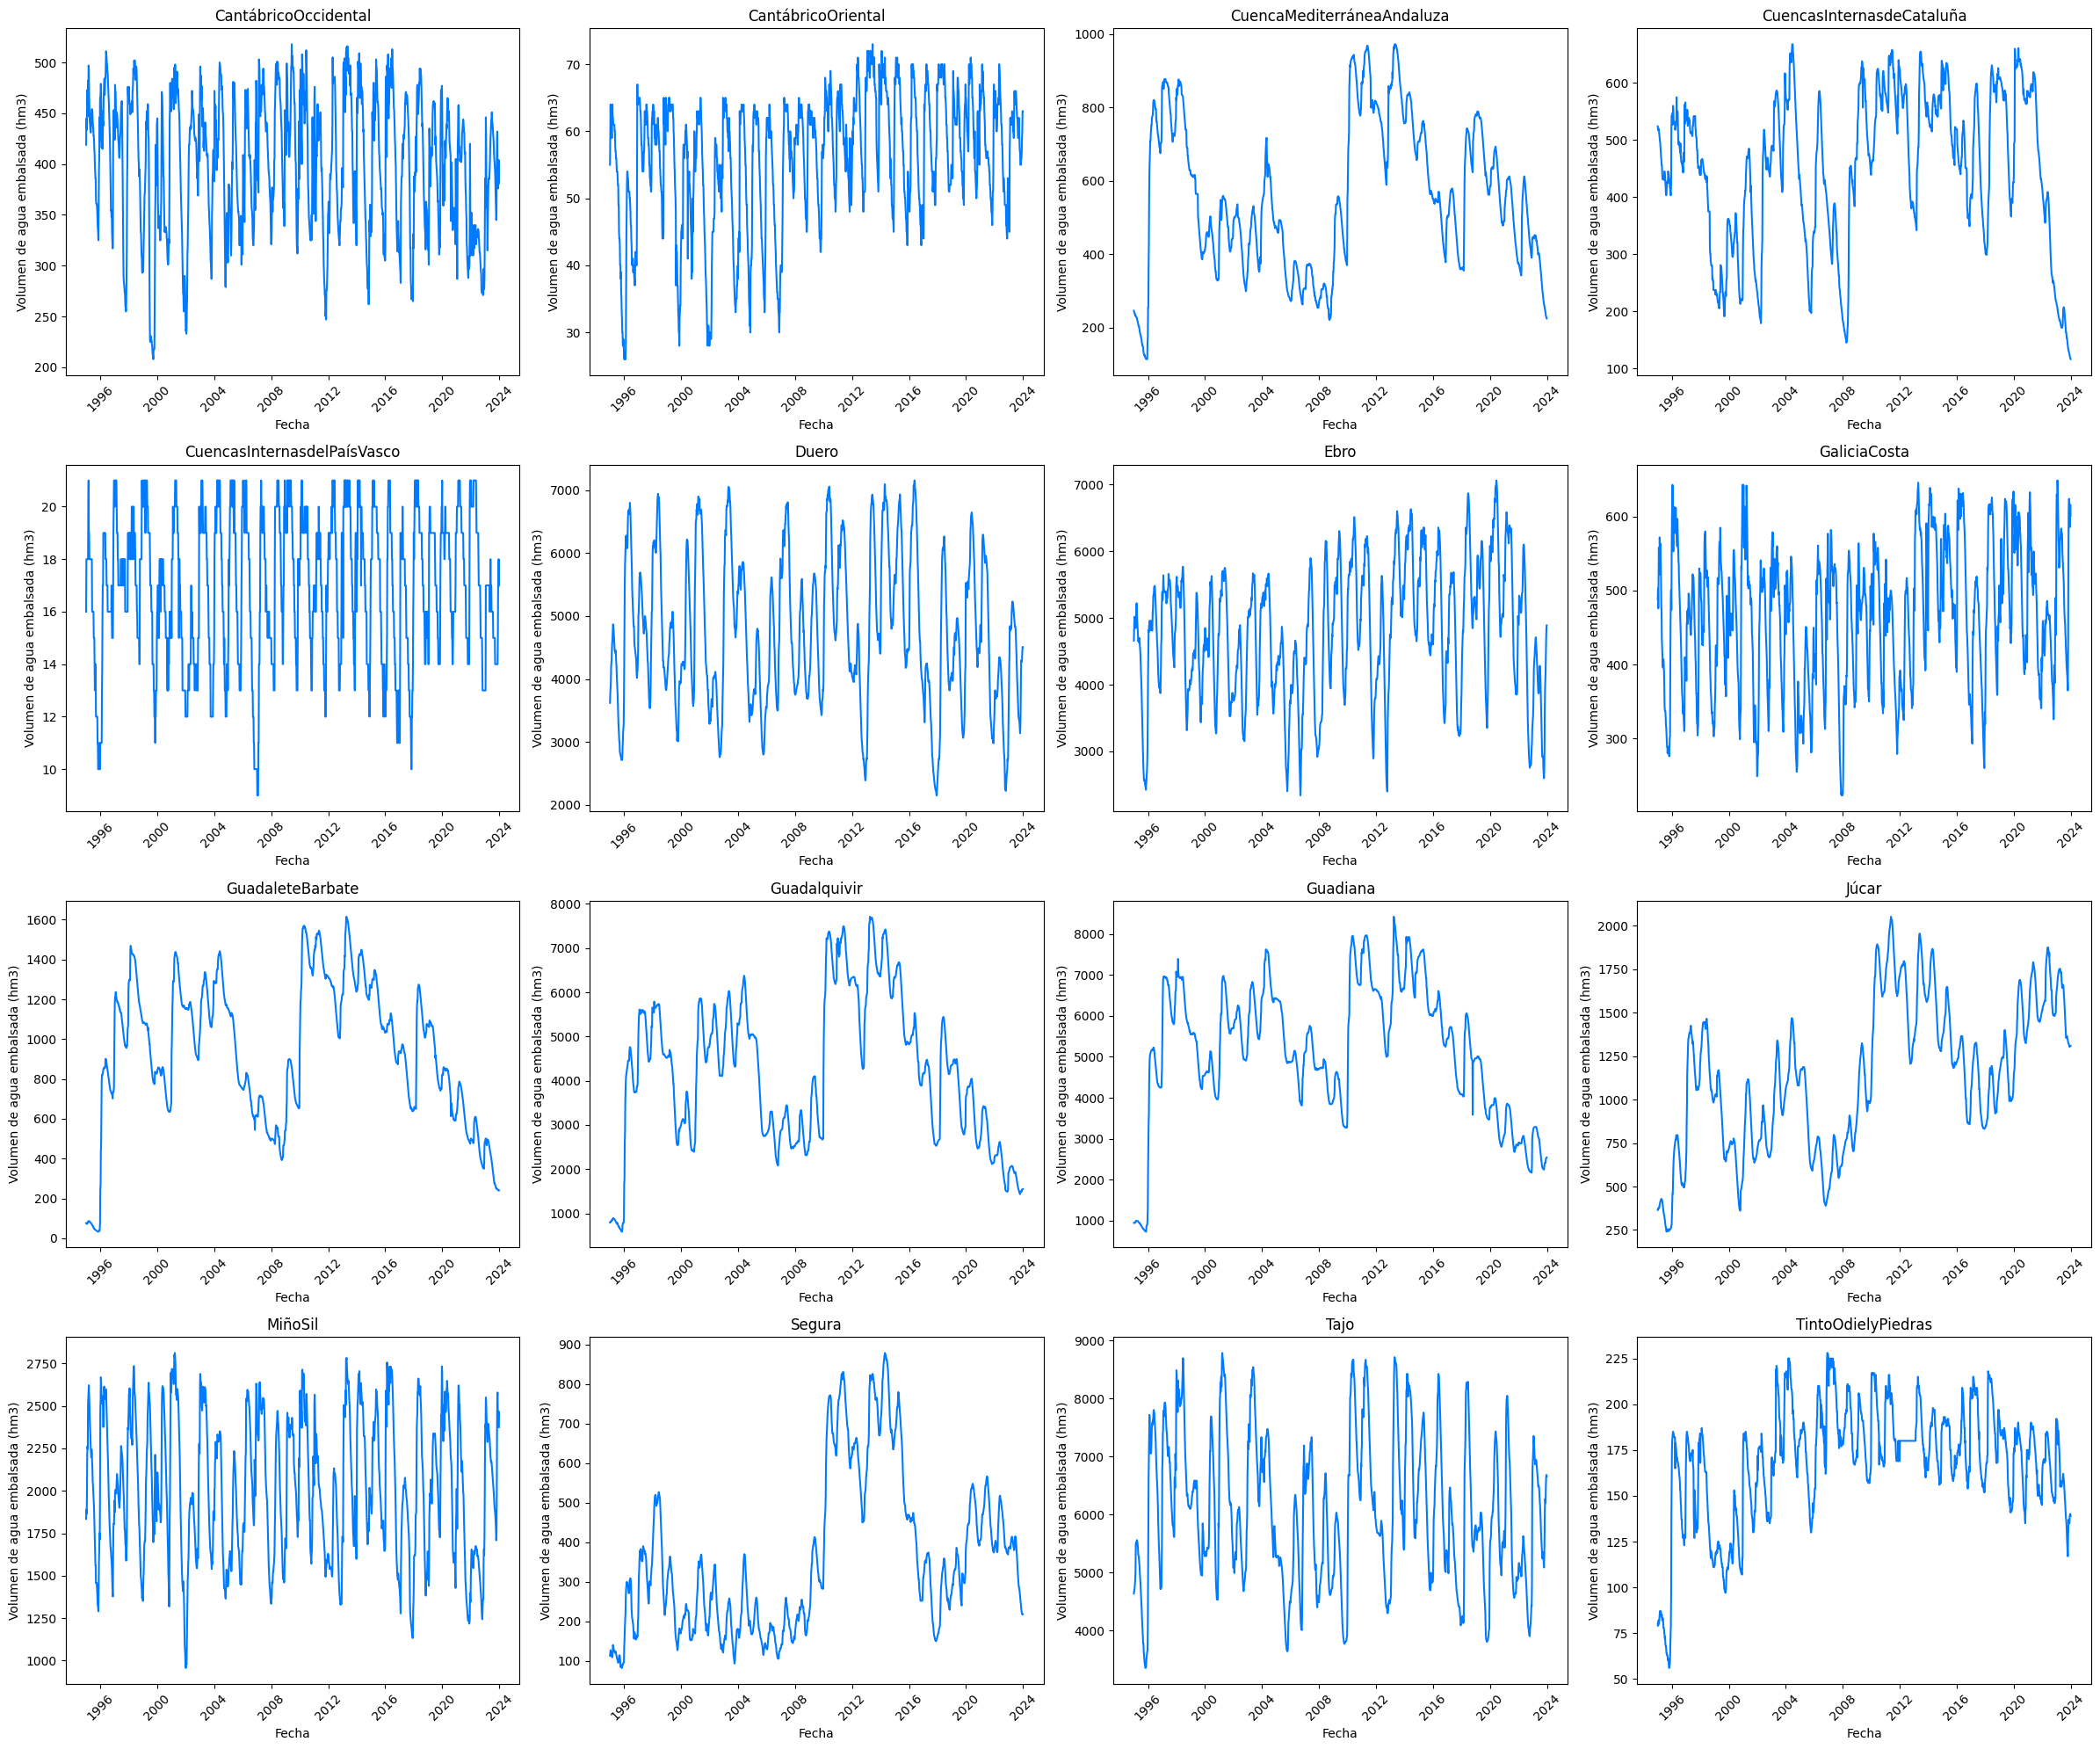

In [18]:
# Filas y columnas para los subplots
nrows = 4
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 20))

# Iterar sobre cada demarcación y agregar al subplot correspondiente
for idx, demarcacion in enumerate(demarcaciones):
    row = idx // ncols
    col = idx % ncols
    df_name = f'df_{demarcacion}'
    if df_name in globals():
        ax = axs[row, col]
        sns.lineplot(data=globals()[df_name], x="fecha", y="volumen_actual", ax=ax, color="#007bff")
        ax.set_title(f'{demarcacion}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Volumen de agua embalsada (hm3)')
        ax.tick_params(axis='x', rotation=45)

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()

## 2.Tratamiento de outliers

Para identificar de forma numérica en que fecha ocurren los outliers utilizaremos una de las formas comunes de identificalos que es mediante el uso de los cuartiles y del rango intercuartil.

In [19]:
def busqueda_outliers(df):
  Q1 = df['volumen_actual'].quantile(0.25)
  Q3 = df['volumen_actual'].quantile(0.75)
  IQR = Q3 -Q1

  umbral_inferior = Q1 - 1.5 * IQR
  umbral_superior = Q3 + 1.5 * IQR

  outliers = df[(df['volumen_actual'] < umbral_inferior) | (df['volumen_actual'] > umbral_superior)]
  return outliers

Se va a generar un bucle para comprobar los outliers en cuanto al volumen embalsado por las demarcaciones hidrograficas:

In [20]:
outliers_dict = {}

# Bucle para verificar outliers en cada DataFrame
for demarcacion in demarcaciones:
    df_name = f'df_{demarcacion}'
    if df_name in globals():
        df = globals()[df_name]
        outliers = busqueda_outliers(df)
        outliers_dict[demarcacion] = outliers
        print(f'Outliers en {demarcacion}:')
        print(outliers)
        print('\n')

Outliers en CantábricoOccidental:
Empty DataFrame
Columns: [fecha, volumen_actual, año, trimestre, mes, semana_año]
Index: []


Outliers en CantábricoOriental:
         fecha  volumen_actual   año  trimestre  mes  semana_año
44  1995-11-07            32.0  1995          4   11          45
45  1995-11-14            30.0  1995          4   11          46
46  1995-11-21            30.0  1995          4   11          47
47  1995-11-28            28.0  1995          4   11          48
48  1995-12-05            28.0  1995          4   12          49
49  1995-12-12            29.0  1995          4   12          50
50  1995-12-19            28.0  1995          4   12          51
51  1995-12-26            27.0  1995          4   12          52
52  1996-01-02            26.0  1996          1    1           1
53  1996-01-09            26.0  1996          1    1           2
54  1996-01-16            27.0  1996          1    1           3
55  1996-01-23            26.0  1996          1    1        

Se observa que solo las demarcaciones del `Cantábrico Oriental` y `Tinto, Odiel y Piedras` tienen outliers en sus volúmenes. El tratamiento de estos outliers es fundamental para que nuestro modelo predictivo sea correcto y reduzcamos su error.

\
Al trabajar con series temporales, **no es posible imputar por la media, moda o mediana**, porque estaríamos incluyendo datos incorrectos y que no se ajustan a la distribución estadística real. En este caso, al trabajar con series temporales, lo habitual es trabajar con **métodos de interpolación** como los siguientes:
* **Interpolación lineal:** rellenamos los outliers utilizando interpolación lineal.
* **Interpolación con spline:** utilizamos spline para una interpolación más suave.
* **Uso de modelos predictivos:** utiliza modelos ARIMA, SARIMA o Prophet para predecir los valores y reemplazar los outliers (muy complejo para el alcance que va a tener este proyecto).

### Interpolación de outliers con Spline

La [interpolación con spline](https://es.mathworks.com/help/matlab/ref/spline.html) es un método avanzado para estimar los valores de una función entre puntos discretos de datos. Se utiliza cuando se desea reconstruir una función suave que pase por los puntos dados, permitiendo capturar mejor las variaciones no lineales o curvas en los datos.

\
Un spline es una función definida por piezas, donde cada pieza es un polinomio. La interpolación spline se refiere específicamente a un tipo de interpolación donde se utilizan polinomios de grado bajo (generalmente polinomios cúbicos) para ajustar segmentos de la función entre los puntos de datos.

In [21]:
def imputar_outliers_spline(df):
    Q1 = df['volumen_actual'].quantile(0.25)
    Q3 = df['volumen_actual'].quantile(0.75)
    IQR = Q3 - Q1

    umbral_inferior = Q1 - 1.5 * IQR
    umbral_superior = Q3 + 1.5 * IQR

    df_imputado = df.copy()
    outliers = (df['volumen_actual'] < umbral_inferior) | (df['volumen_actual'] > umbral_superior)

    # Reemplazar los outliers con NaN
    df_imputado.loc[outliers, 'volumen_actual'] = np.nan
    # Interpolar los NaN usando spline y por tanto, haciendo un tratamiento de interpolación sobre los outliers
    df_imputado['volumen_actual'] = df_imputado['volumen_actual'].interpolate(method='spline', order=3)

    return df_imputado

In [22]:
df_CantábricoOriental = imputar_outliers_spline(df_CantábricoOriental)

In [23]:
df_TintoOdielyPiedras = imputar_outliers_spline(df_TintoOdielyPiedras)

Una vez se han tratado los outliers de las demarcaciones hidrográficas y tenemos la información limpia y ordenada, ya podemos pasar a la creación del modelo predictivo.

## 3.Modelo predictivo del volumen embalsado. XGBoost

Una buena practica previa a la definición del modelo es plotear gráficas de cajas (boxplots) con los valores de los volúmenes según los atributos temporales (año, trimestre, mes, semana_año) para entender la distribucción e importancia de cada uno de ellos dentro de la serie temporal. Se va a realizar un ejemplo con el conjunto de datos correspondientes a la demarcación hidrográfica del `Catábrico Occidental`

<ipython-input-24-eecdf77d3da1>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())  # Rotación del eje x
<ipython-input-24-eecdf77d3da1>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())  # Rotación del eje x
<ipython-input-24-eecdf77d3da1>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)  # Rotación del eje x
<ipython-input-24-eecdf77d3da1>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)  # Rotación del eje x


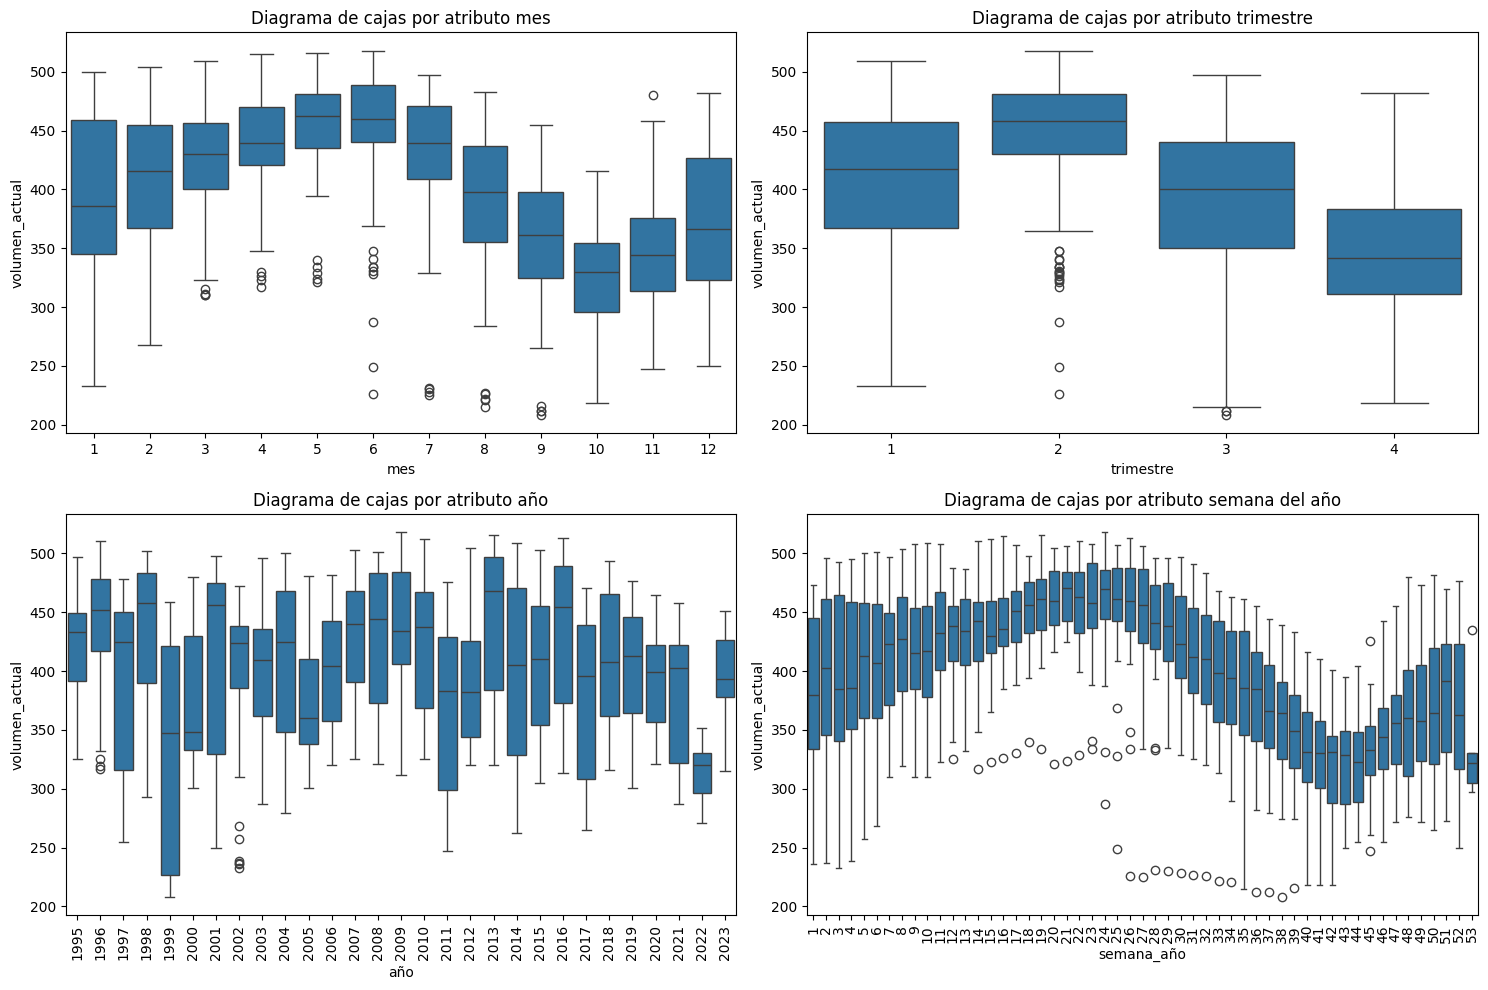

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Diagrama de cajas por atributo mes
sns.boxplot(data=df_CantábricoOccidental, x="mes", y="volumen_actual", ax=axes[0, 0]).set_title("Diagrama de cajas por atributo mes")
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())  # Rotación del eje x

# Diagrama de cajas por atributo trimestre
sns.boxplot(data=df_CantábricoOccidental, x="trimestre", y="volumen_actual", ax=axes[0, 1]).set_title("Diagrama de cajas por atributo trimestre")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())  # Rotación del eje x

# Diagrama de cajas por atributo año
sns.boxplot(data=df_CantábricoOccidental, x="año", y="volumen_actual", ax=axes[1, 0]).set_title("Diagrama de cajas por atributo año")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)  # Rotación del eje x

# Diagrama de cajas por atributo día de la semana
sns.boxplot(data=df_CantábricoOccidental, x="semana_año", y="volumen_actual", ax=axes[1, 1]).set_title("Diagrama de cajas por atributo semana del año")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)  # Rotación del eje x

plt.tight_layout()
plt.show()

* Para poder plotear los boxplots y poder así visualizar la distribucción de volúmenes embalsados de cada una de las demarcaciones hidrográficas vamos a crear primero una función que permita dibujar dichos gráficos:

In [25]:
def crear_boxplots(df, demarcacion):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Boxplots para la Demarcación Hidrográfica: {demarcacion}', fontsize=16)

    # Diagrama de cajas por atributo mes
    sns.boxplot(data=df, x="mes", y="volumen_actual", ax=axes[0, 0]).set_title("Diagrama de cajas por atributo mes")
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())

    # Diagrama de cajas por atributo trimestre
    sns.boxplot(data=df, x="trimestre", y="volumen_actual", ax=axes[0, 1]).set_title("Diagrama de cajas por atributo trimestre")
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())

    # Diagrama de cajas por atributo año
    sns.boxplot(data=df, x="año", y="volumen_actual", ax=axes[1, 0]).set_title("Diagrama de cajas por atributo año")
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)

    # Diagrama de cajas por atributo semana del año
    sns.boxplot(data=df, x="semana_año", y="volumen_actual", ax=axes[1, 1]).set_title("Diagrama de cajas por atributo semana del año")
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar el layout y dejar espacio para el título
    plt.show()

In [26]:
# Listado de los dataframes y sus nombres
dataframes = {
    'Cantábrico Occidental': df_CantábricoOccidental,
    'Cantábrico Oriental': df_CantábricoOriental,
    'Cuenca Mediterránea Andaluza': df_CuencaMediterráneaAndaluza,
    'Cuencas Internas de Cataluña': df_CuencasInternasdeCataluña,
    'Cuencas Internas del País Vasco': df_CuencasInternasdelPaísVasco,
    'Duero': df_Duero,
    'Ebro': df_Ebro,
    'Galicia Costa': df_GaliciaCosta,
    'Guadalete Barbate': df_GuadaleteBarbate,
    'Guadalquivir': df_Guadalquivir,
    'Guadiana': df_Guadiana,
    'Júcar': df_Júcar,
    'Miño Sil': df_MiñoSil,
    'Segura': df_Segura,
    'Tajo': df_Tajo,
    'Tinto Odiel y Piedras': df_TintoOdielyPiedras
}

Con un bucle for, se recorren todas las demarcaciones y se generan los boxplot de cada una de ellas.

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


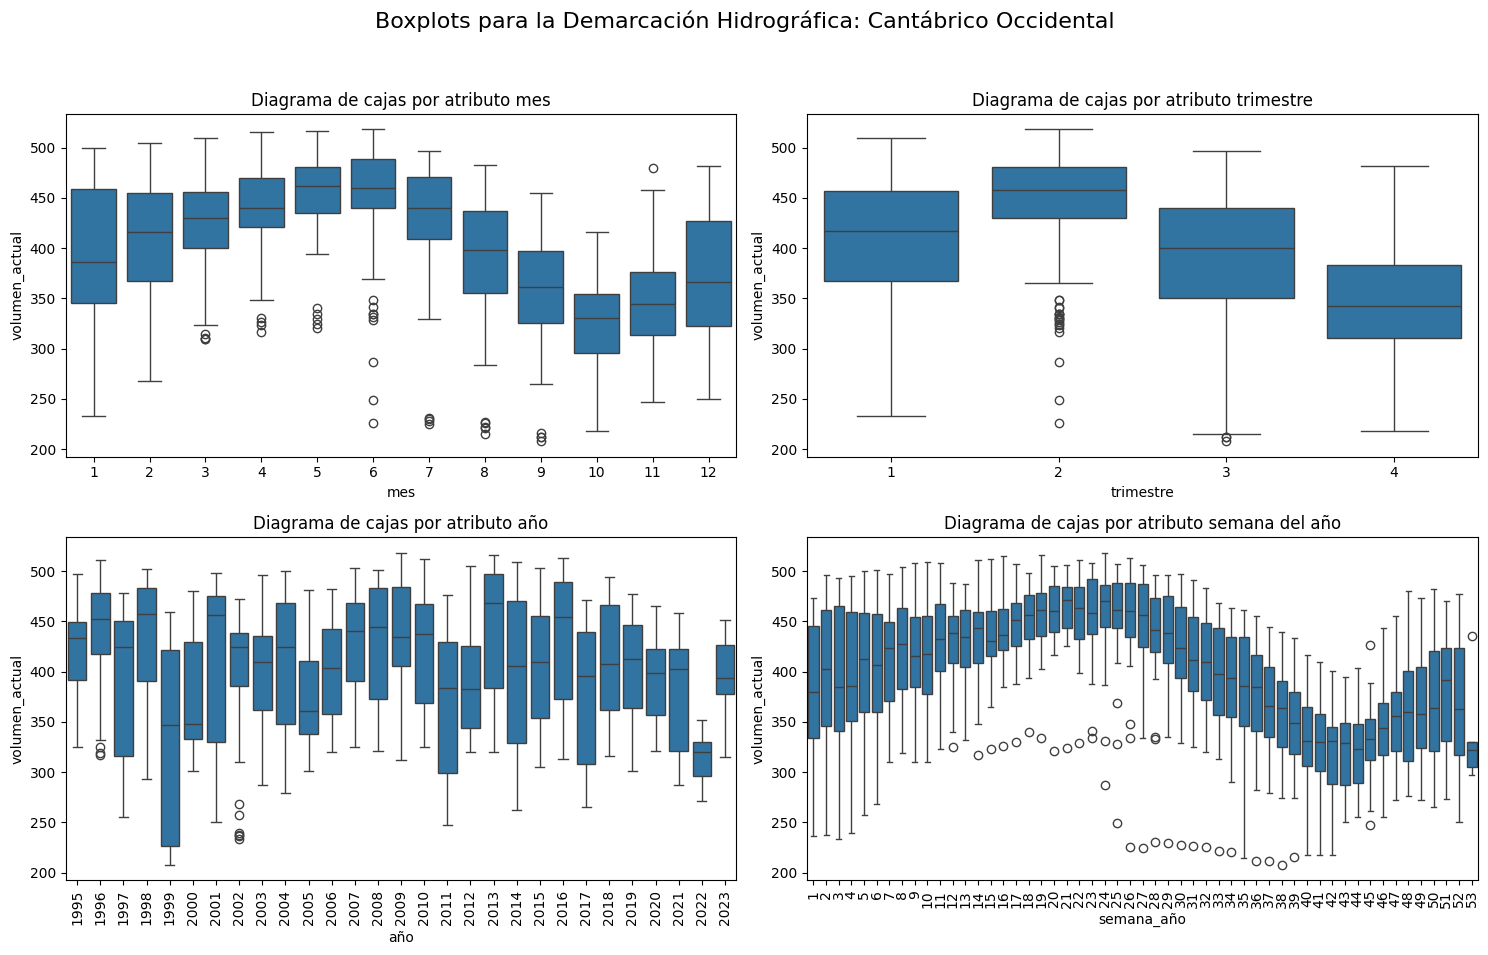

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


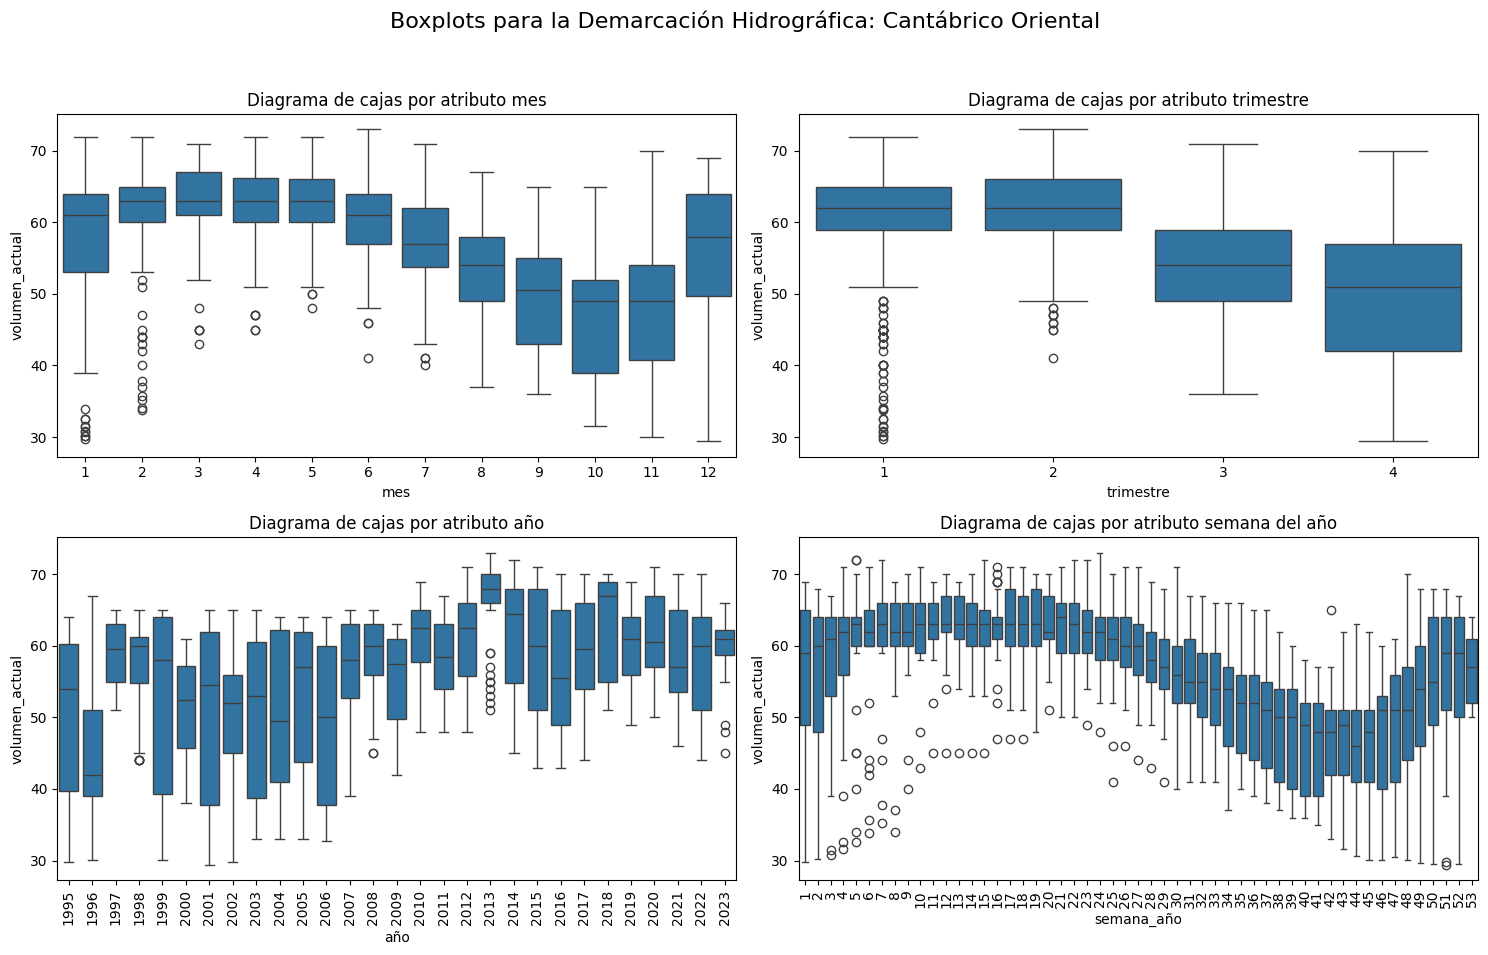

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


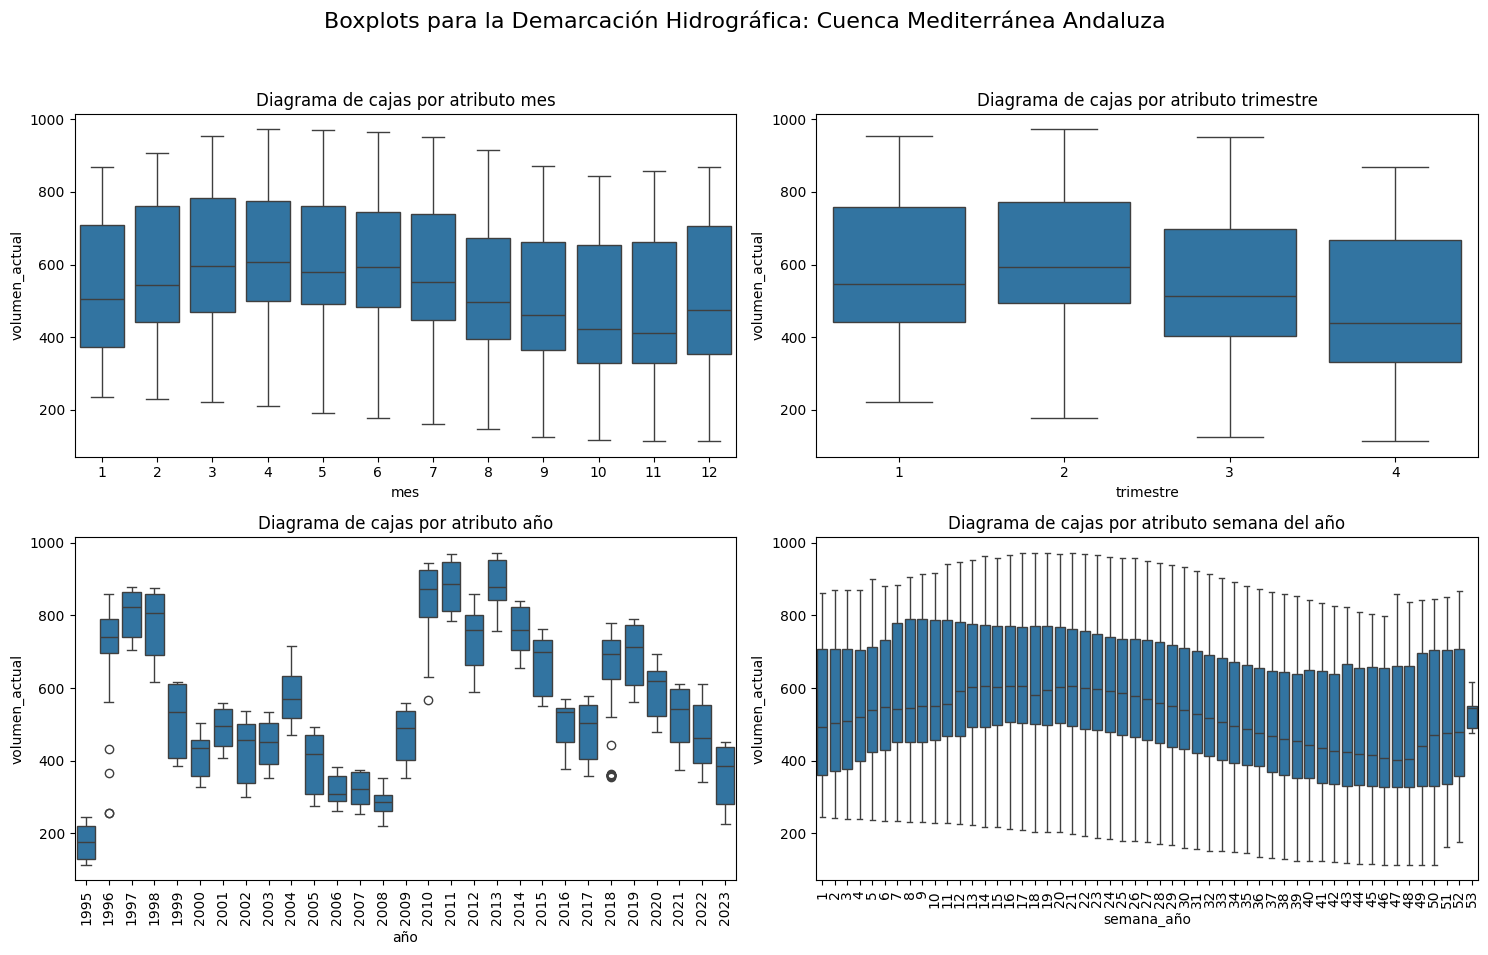

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


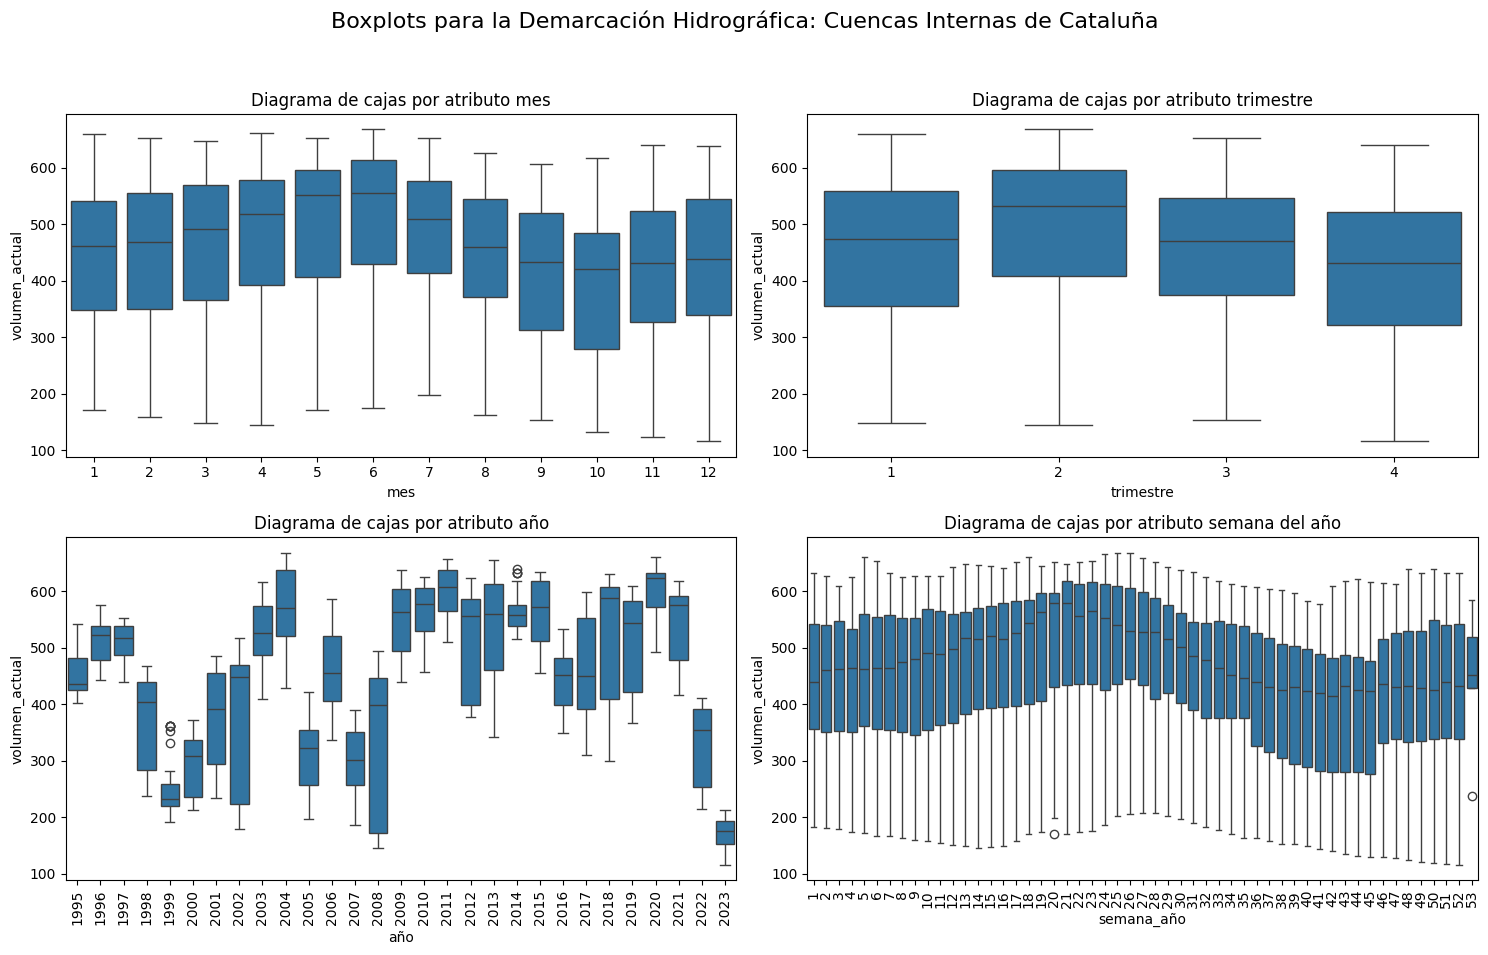

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


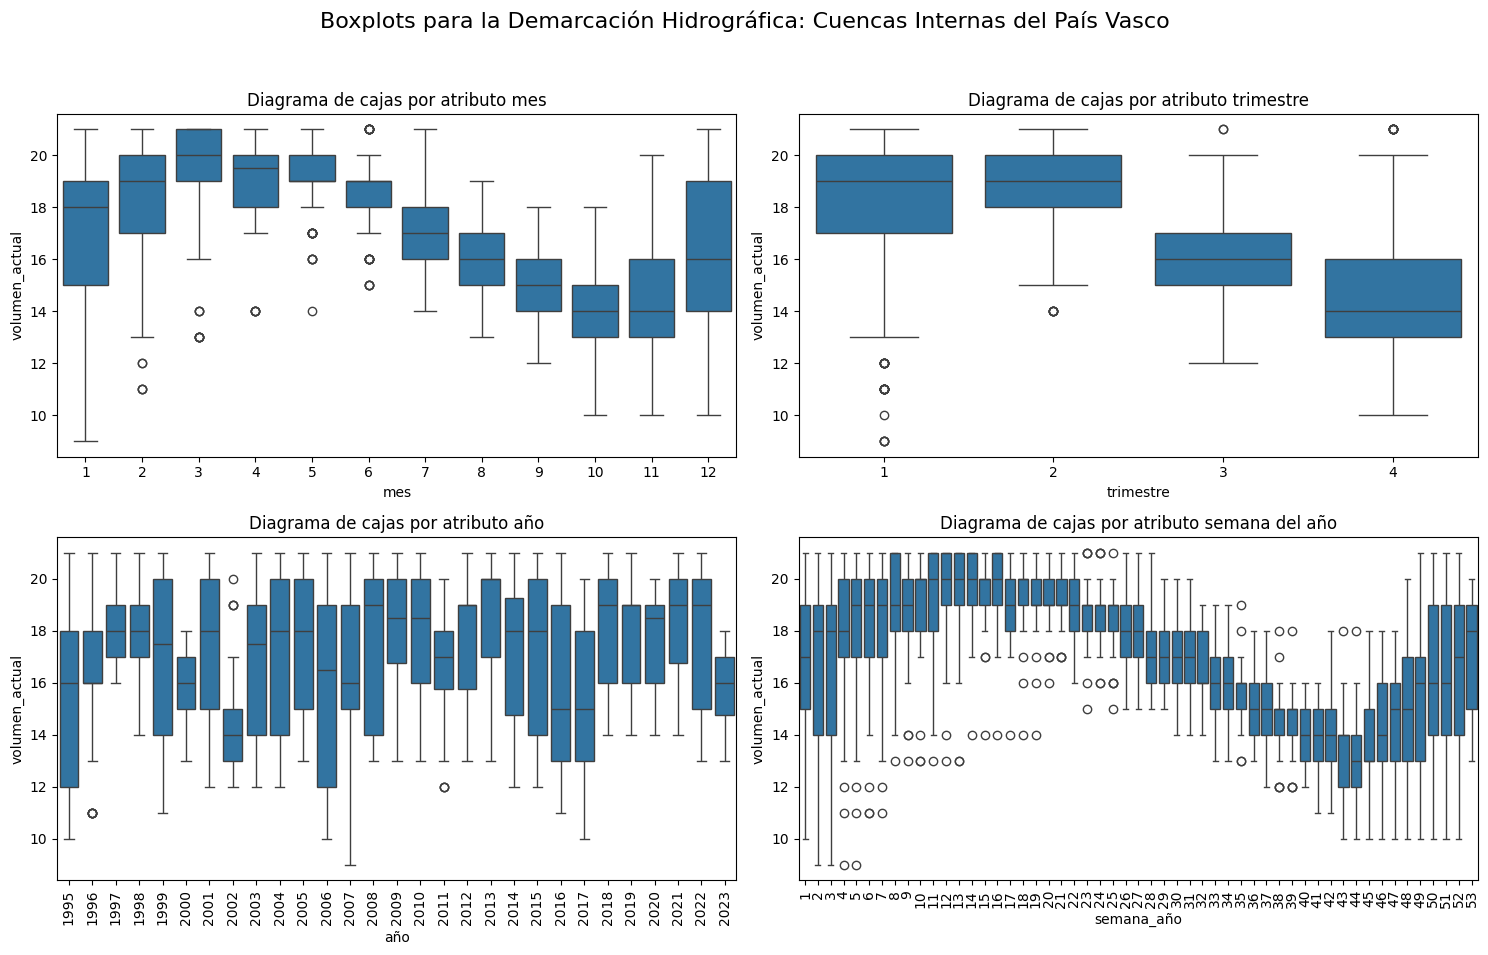

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


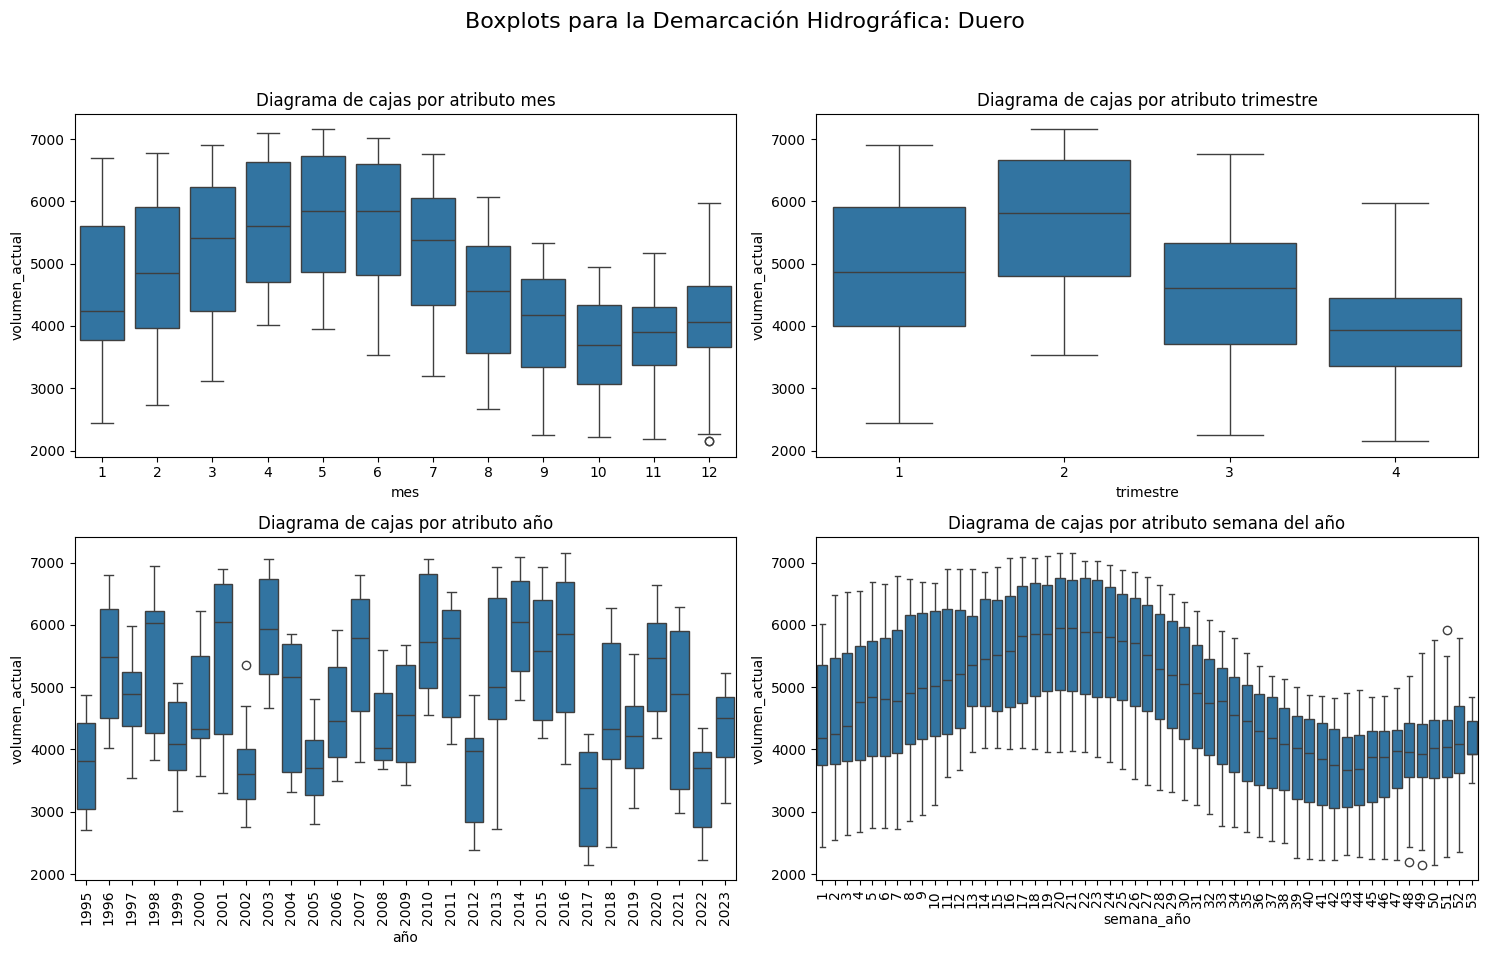

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


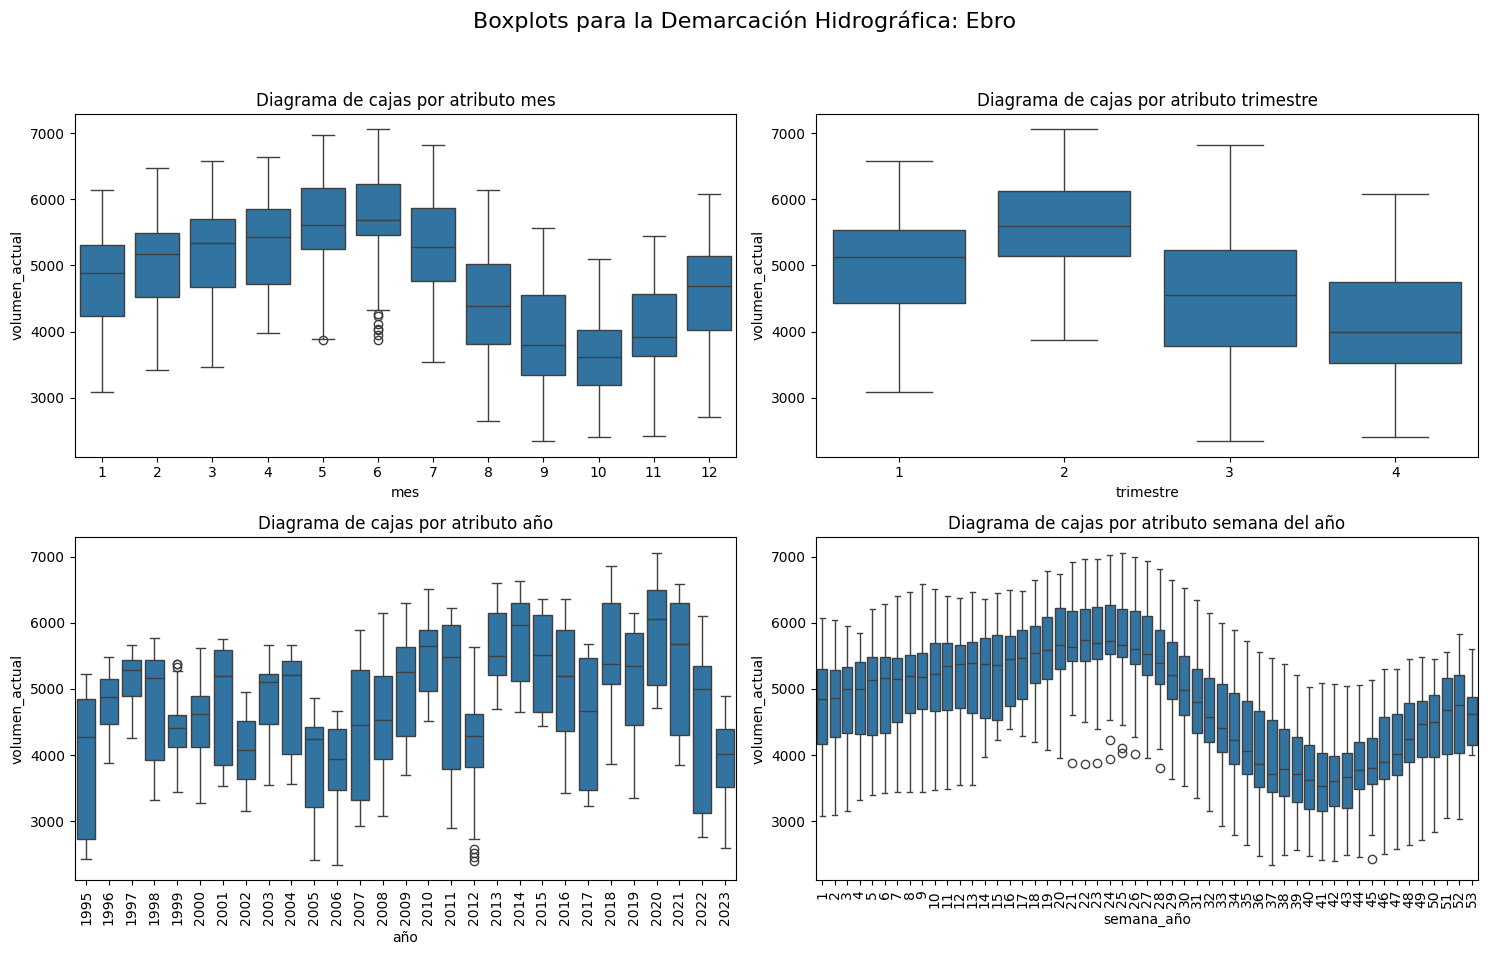

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


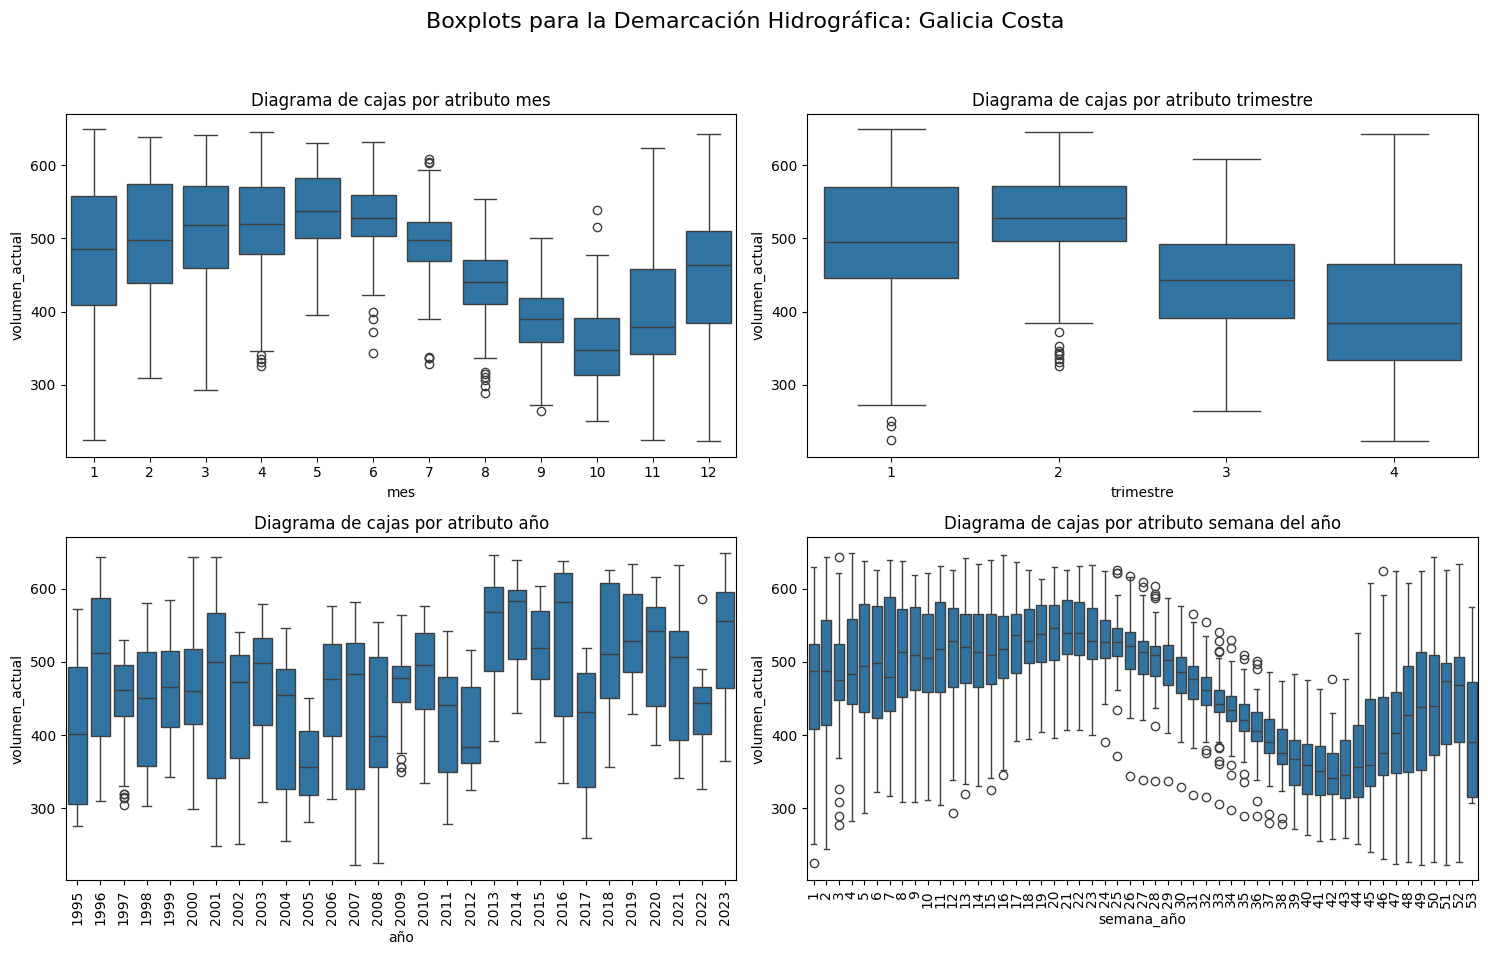

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


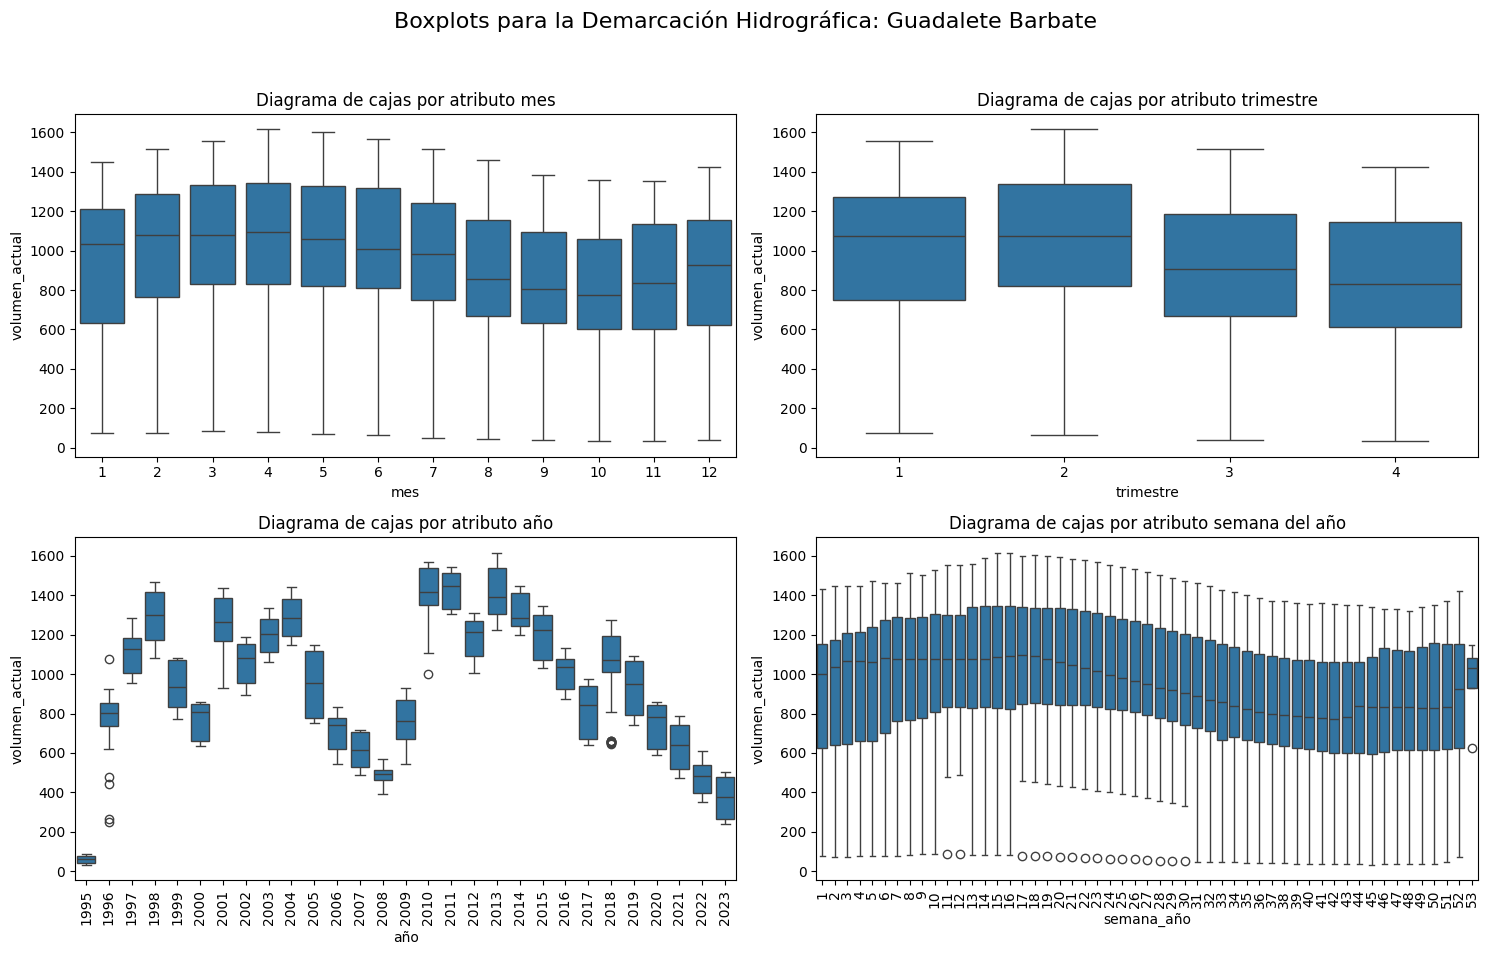

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


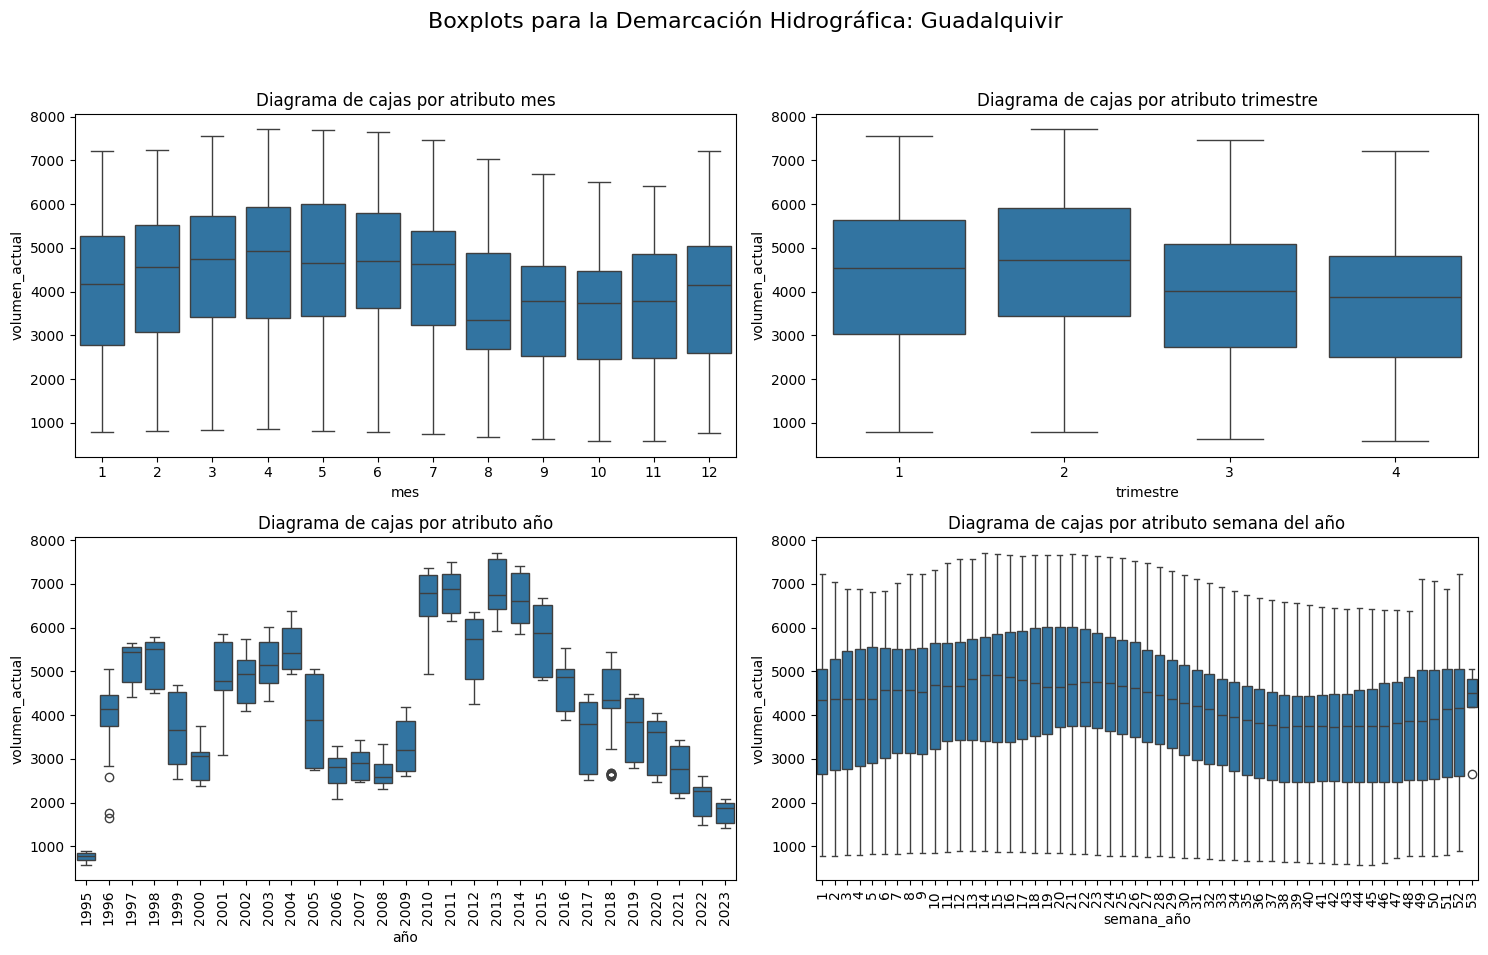

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


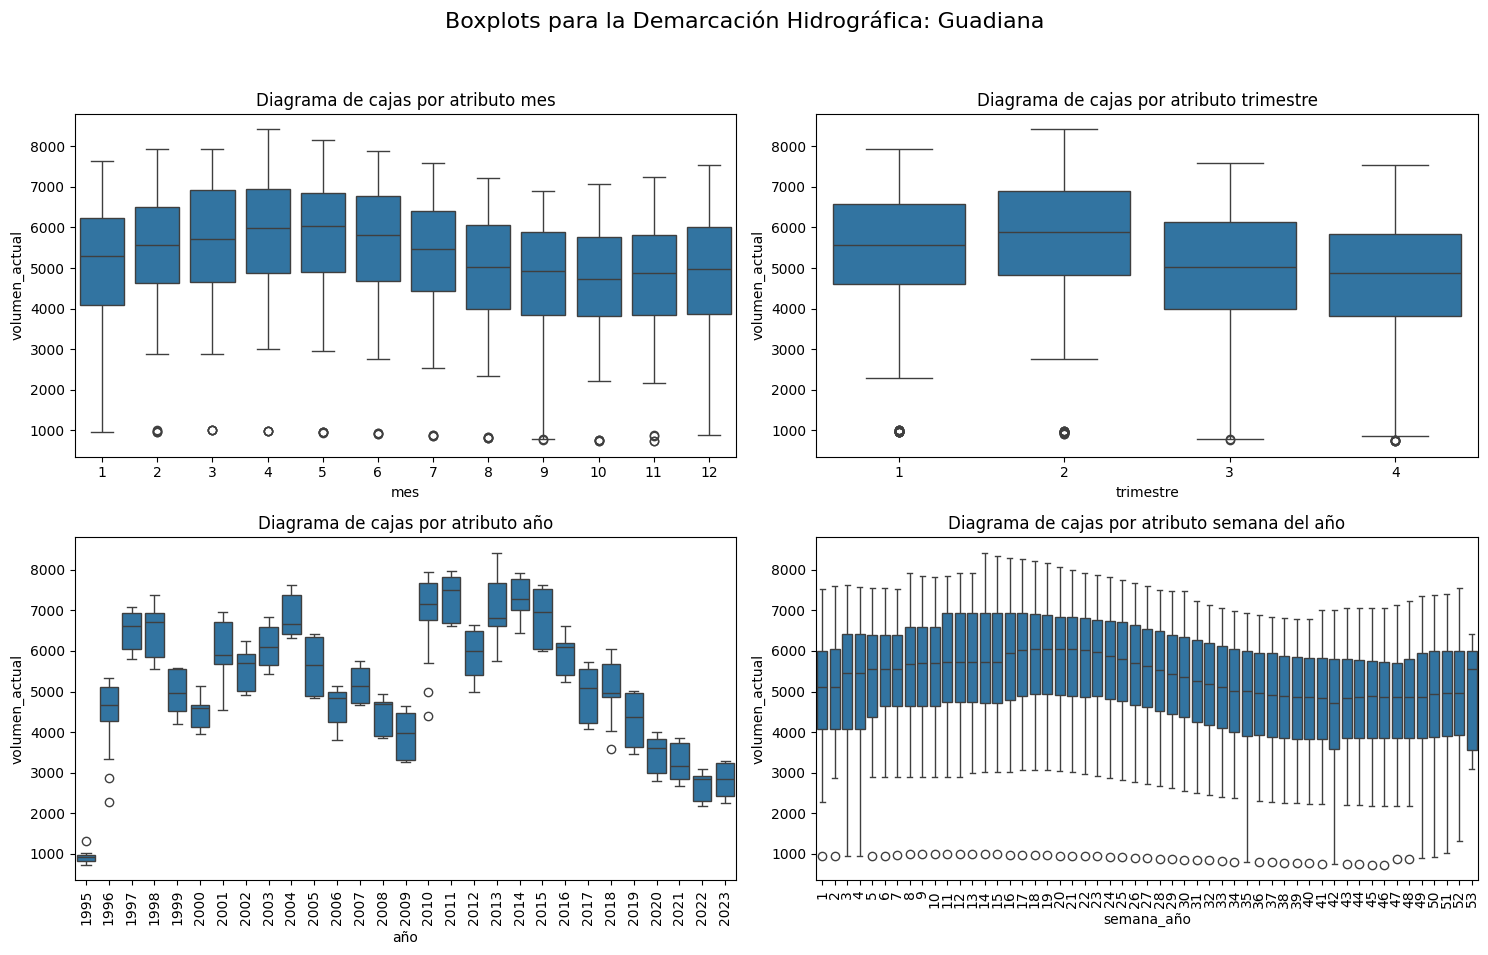

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


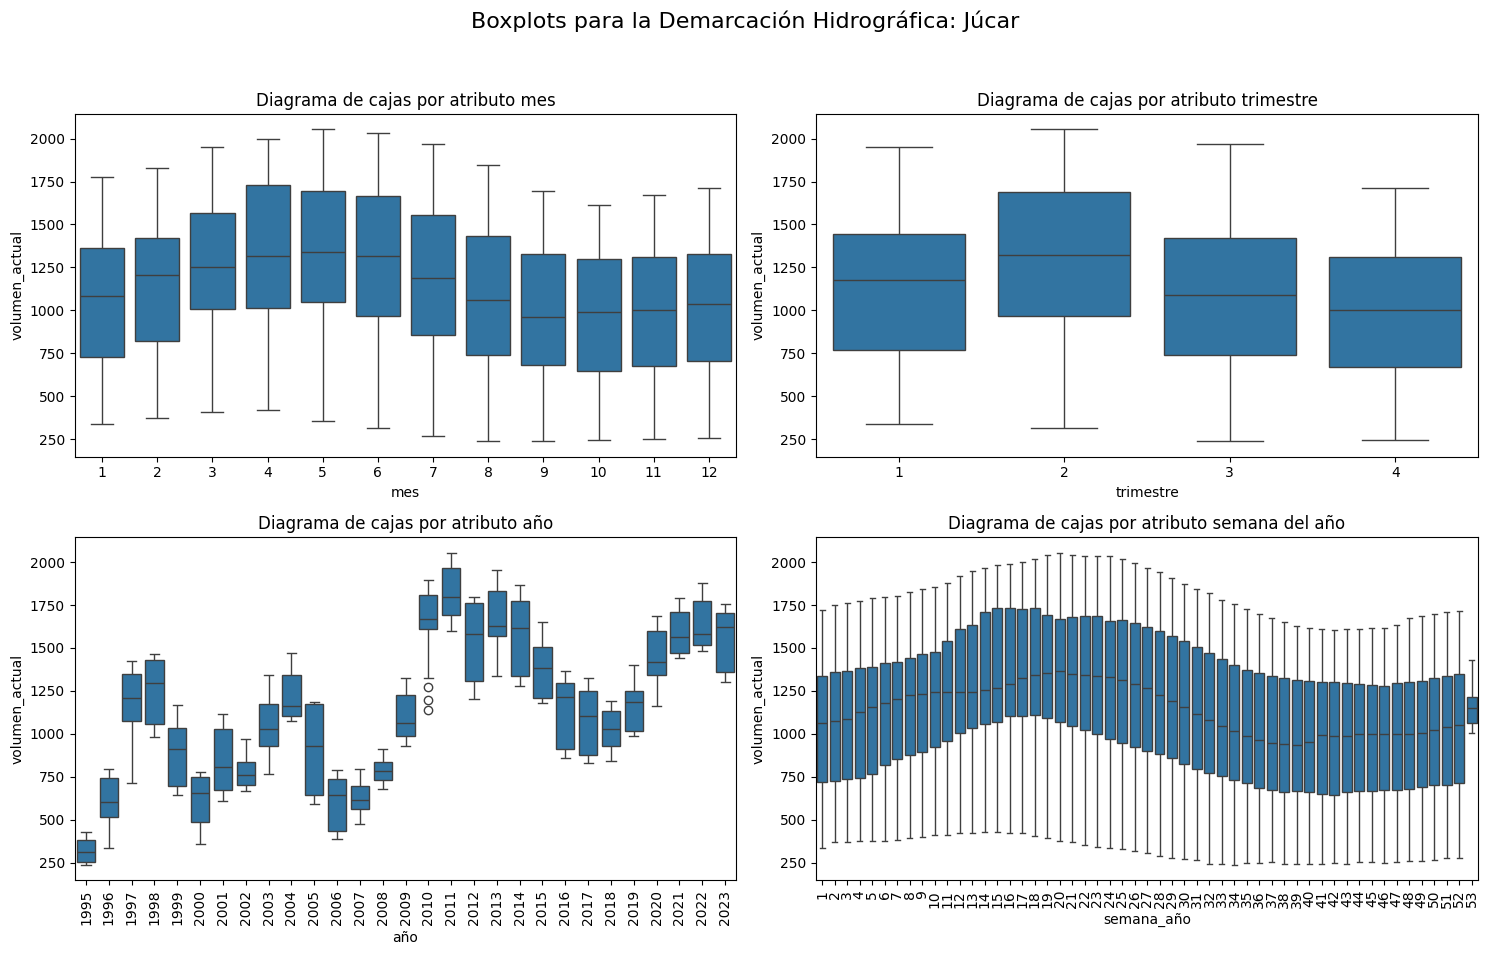

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


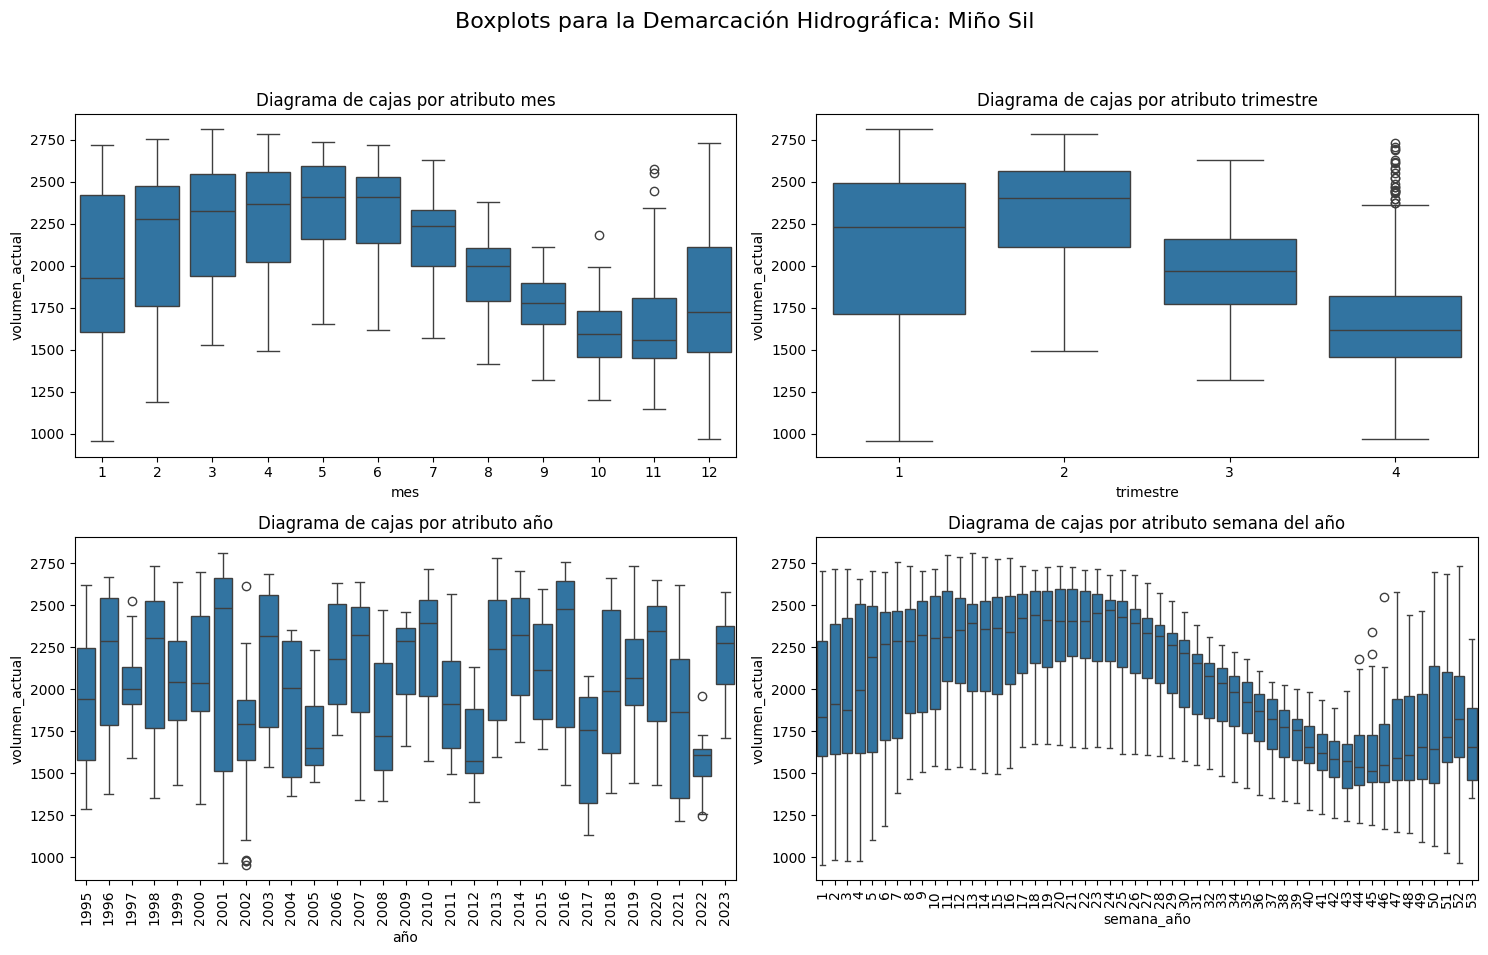

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


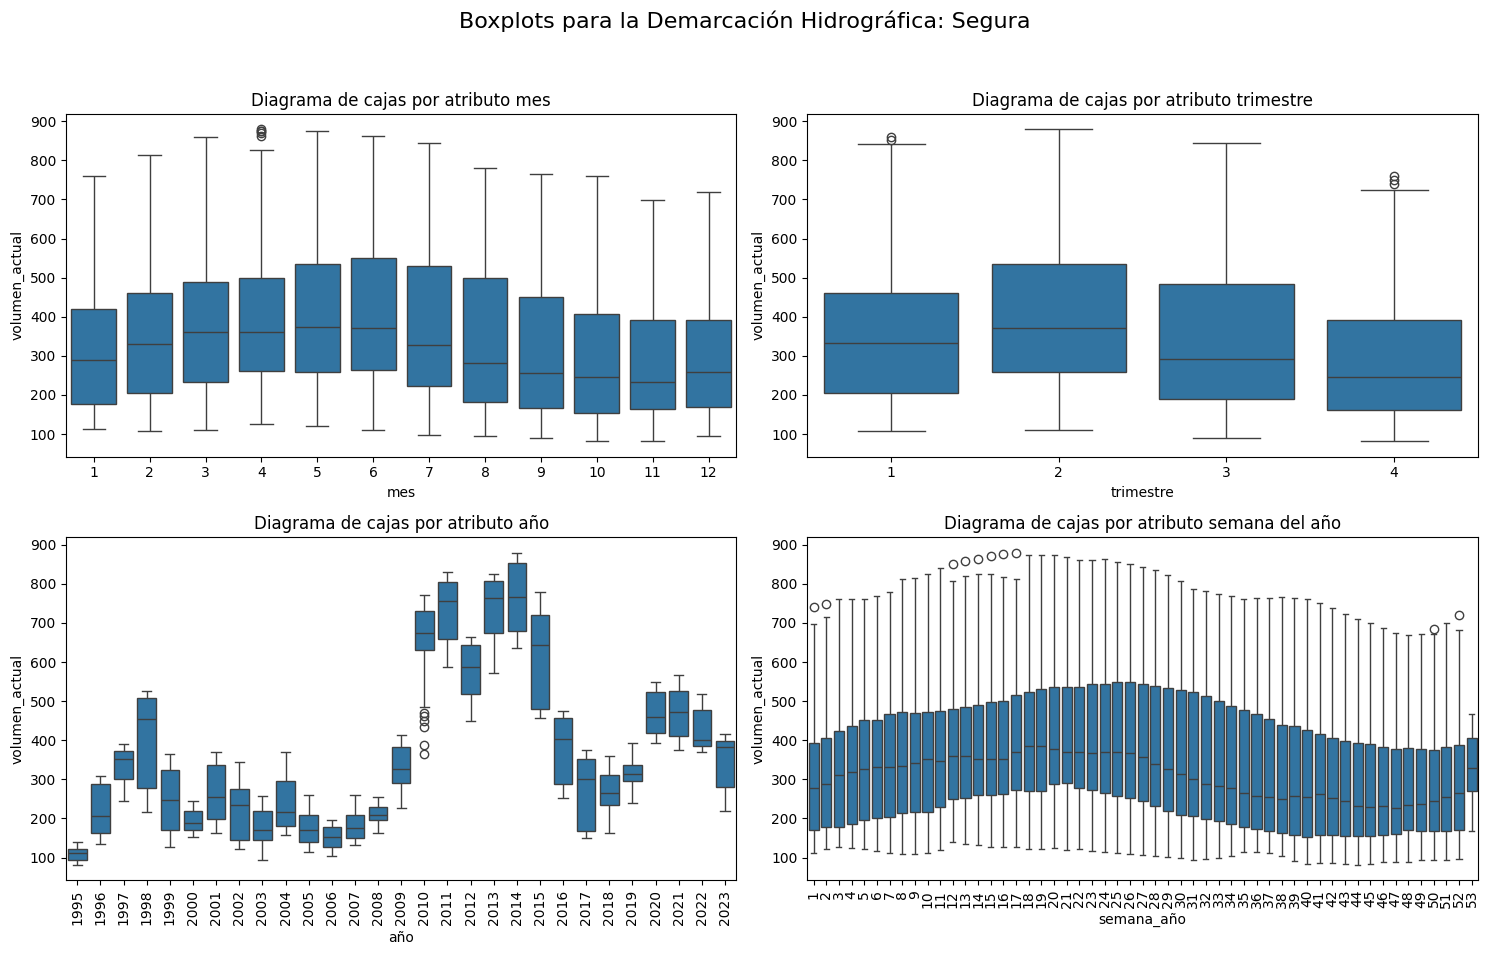

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


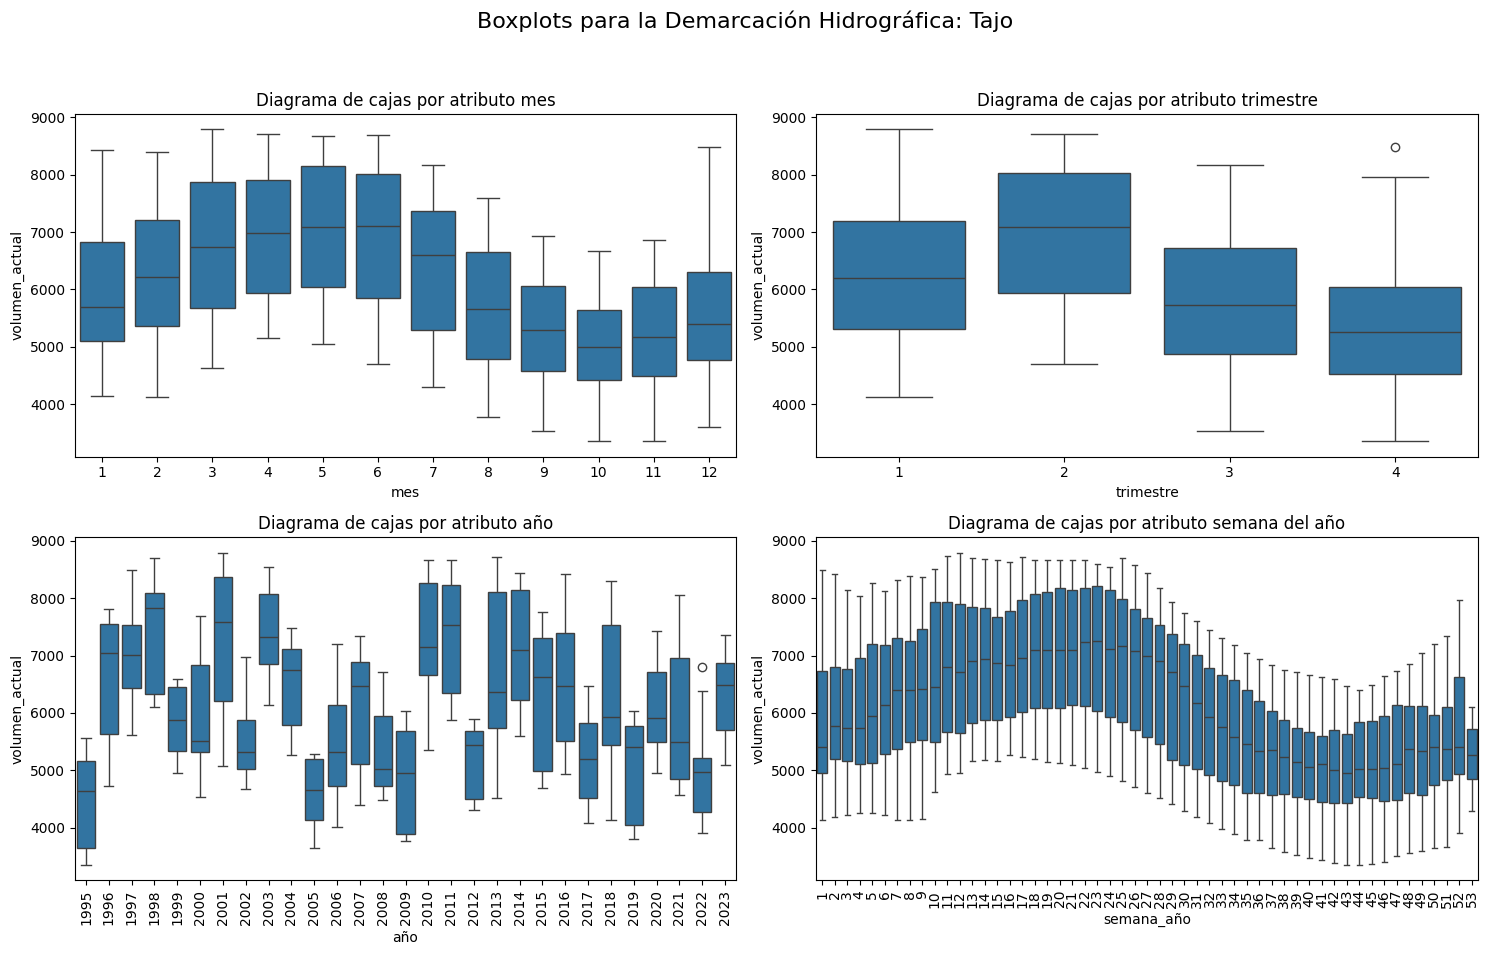

<ipython-input-25-68d5309c12ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels())
<ipython-input-25-68d5309c12ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels())
<ipython-input-25-68d5309c12ef>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
<ipython-input-25-68d5309c12ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)


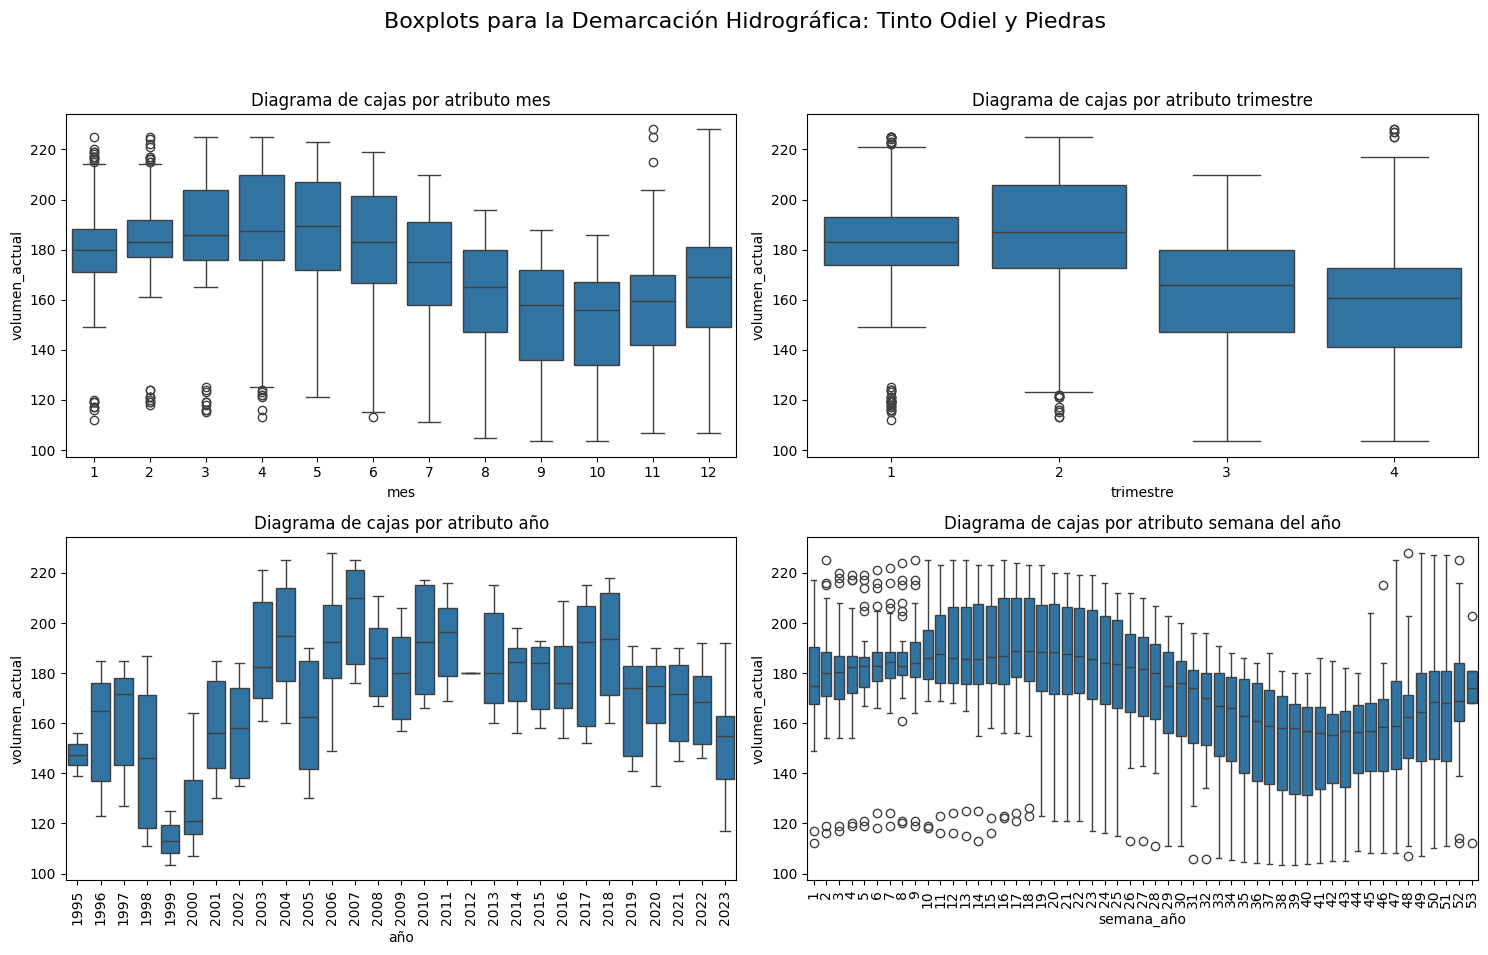

In [27]:
for demarcacion, df in dataframes.items():
    crear_boxplots(df, demarcacion)

### Conclusiones obtenidas de las visualizaciones

* Se observa como, independientemente de la demarcación, los primeres meses del año el volumen de los embalses va aumentando. Esto se produce porque generalmente, los últimos y los primeros meses del año se corresponden con los meses de mayores precipitaciones, por tanto, durante esos meses se produce una mayor acumulación de volumen de agua en los embalses. A continuación se muestra una imagen en la que se observa la [distribución mensual de las lluvias en España](https://es.weatherspark.com/countries/ES#Figures-Rainfall).
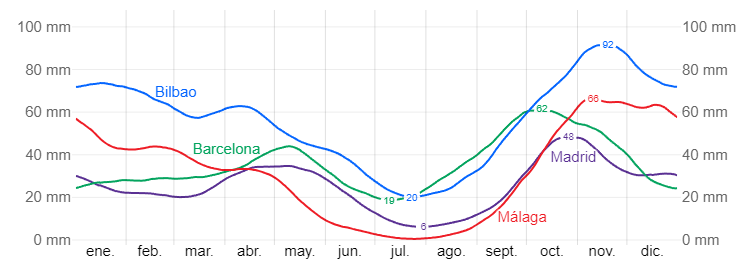

Como se ha mencionado anteriormente, se va a realizar un modelo para cada una de las demarcaciones hidrograficas existentes en España. Esto se debe a que cada una de estas demarcaciones cuenta con una serie de particularidades debido a su localización, por ejemplo, las demarcaciones del Sur y Sur-Este como la del Segura, tienen problemas de precipitación (sequías) constantemente, mientras que otras demarcaciones en el norte del país, cuentan con una mayor cantidad de precipitaciones, por lo que la distribución del agua embalsada puede variar considerablemente entre algunas demarcaciones.

\
Además, extraemos predicciones específicas para cada una de las demarciciones, lo cual puede ser de gran utilidad cuando se realice el dashboard en PowerBI para poder estudiar cada una de las demarcaciones particularmente.

### 3.1 Entrenamiento del modelo. Caso particular: demarcación del Duero.

**Se va a realizar el desarrollo del modelo particularizado para una demarcación específica**, que en este caso será la del `Duero`. **Esto se hace para poder realizar explicaciones detalladas sobre el modelo predictivo** para un solo caso, ya que si no sería necesario particularizar el modelo para cada demarcación y no se cumpliría con el plazo de tiempo estipulado para la realización del proyecto.

In [28]:
separar_demarcaciones_crear_dfs(df_demarcaciones)

In [29]:
df_Duero.tail()

fecha  volumen_actual   año  trimestre  mes  semana_año
1508 2023-11-28          4272.0  2023          4   11          48
1509 2023-12-05          4303.0  2023          4   12          49
1510 2023-12-12          4436.0  2023          4   12          50
1511 2023-12-19          4510.0  2023          4   12          51
1512 2023-12-26          4508.0  2023          4   12          52

In [30]:
df_Duero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha           1513 non-null   datetime64[ns]
 1   volumen_actual  1513 non-null   float64       
 2   año             1513 non-null   int32         
 3   trimestre       1513 non-null   int32         
 4   mes             1513 non-null   int32         
 5   semana_año      1513 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(3)
memory usage: 48.9 KB


<Axes: xlabel='fecha'>

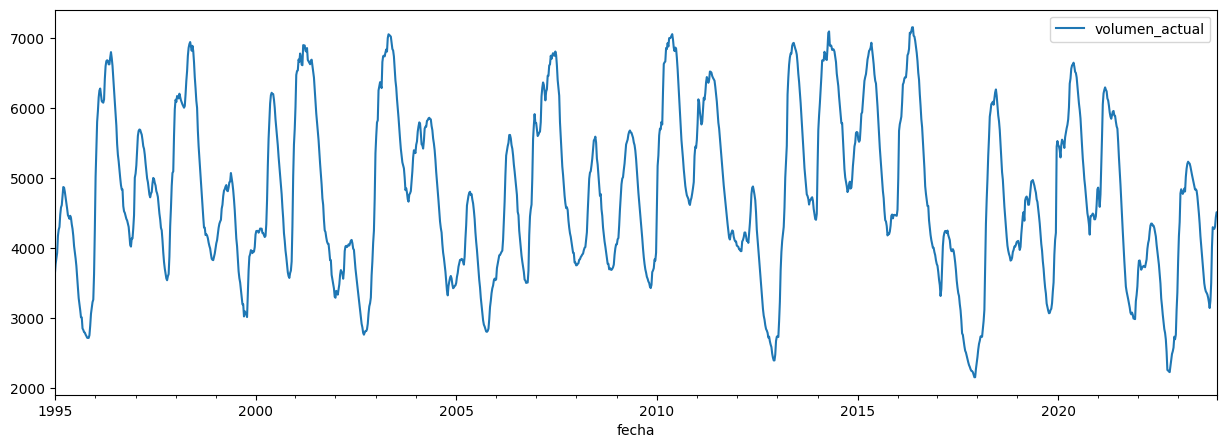

In [31]:
df_Duero.plot(figsize=(15,5), x='fecha', y='volumen_actual', linestyle='-')

* Dividimos los datos en set de entrenamiento y set de validación ploteandolos a continuación para apreciar la división de forma visual.

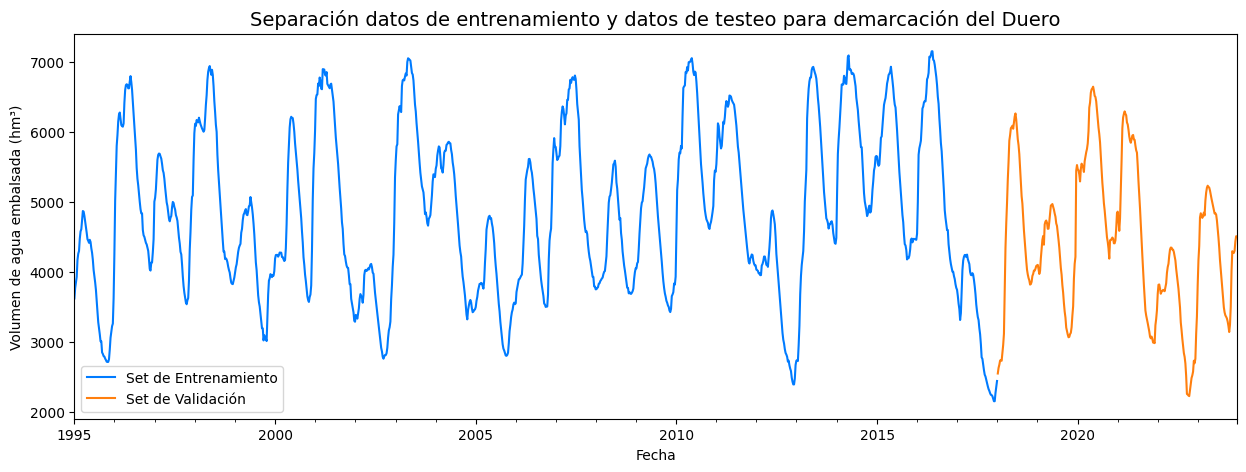

In [32]:
# Dividimos la tabla de datos en dos sets, uno para el entrenamiento (23 años = 70%) y el otro para la validación (6 años = 30%)
train_duero = df_Duero.loc[df_Duero["fecha"] <= pd.to_datetime('2018-01-02')]
test_duero = df_Duero.loc[df_Duero["fecha"] > pd.to_datetime('2018-01-02')]

fig, ax = plt.subplots(figsize=(15, 5))

train_duero.plot(ax=ax, x='fecha', y='volumen_actual', label='Set de Entrenamiento', color='#007bff')
test_duero.plot(ax=ax, x='fecha', y='volumen_actual', label='Set de Validación', color='#ff7f0e')

# Añadir título y etiquetas
plt.title('Separación datos de entrenamiento y datos de testeo para demarcación del Duero', fontsize=14)
plt.xlabel('Fecha', fontsize=10)
plt.ylabel('Volumen de agua embalsada (hm³)', fontsize=10)
plt.legend()

plt.show()

Dividimos los sets de entrenamiento y de validación según sus `features` y la variable objetivo `target`.

In [33]:
features = ["año",'trimestre', 'mes', 'semana_año']
target = 'volumen_actual'

In [34]:
# Dividimos los sets de entrenamiento y validación según las listas creadas anteriormente
X_train = train_duero[features]
y_train = train_duero[target]

X_test = test_duero[features]
y_test = test_duero[target]


Definimos y entrenamos el modelo. Para ello utilizamos los sets de entrenamiento y validación generados en puntos anteriores y realizamos un ajuste de los distintos parámetros del modelo. Como se ha mencionado en el noteebok de procesamiento de datos y en apartados anteriores, el modelo que se va a utilizar pertenece a la librería [xgboost](https://xgboost.readthedocs.io/en/stable/), que es una librería de Python para la implementación de algoritmos de machine learning en el marco de **Gradient Boosting**.

\
**Gradient Boosting** es un poderoso método de machine learning utilizado tanto para tareas de clasificación como de regresión. La idea fundamental detrás de Gradient Boosting es construir modelos secuenciales (habitualmente árboles de decisión) de tal manera que cada modelo intente corregir los errores de los modelos anteriores. Existe una secuencialida, es decir, los modelos se construyen uno tras otro, cada nuevo modelo intenta corregir los errores de predicción de los modelos anteriores. En cada paso, el nuevo modelo se entrena en el residual de las predicciones del modelo anterior, es decir, en el error cometido por los modelos anteriores, lo cual permite reducir el error total de nuestros modelos. La combinación de todos los modelos secuenciales resulta en un modelo final que usualmente tiene una **alta capacidad predictiva**.

**XGBoost** (Extreme Gradient Boosting) es una librería de machine learning optimizada y distribuida que implementa el algoritmo de Gradient Boosting de manera eficiente. En concreto se va a utilizar la clase **XGBRegressor**, que se utiliza específicamente para problemas de regresión. Implementa el algoritmo de Extreme Gradient Boosting (XGBoost) optimizado para tareas de predicción continua, es decir, se utiliza para tareas donde el objetivo es predecir un valor continuo. Otra de las ventajas de esta clase es que implementa directamente las regularizaciones L1 (**Lasso**) y L2 (**Ridge**) para prevenir el overfitting y mejorar la capacidad de generalización del modelo. Ambas técnicas añaden una penalización al modelo por la magnitud de los coeficientes, pero lo hacen de diferentes maneras.

\
Los parámetros que vamos a pasarle al modelo son:
* `n_estimators` : número de árboles (estimadores) a construir en el modelo
* `early_stopping_rounds` : detiene el entrenamiento antes si no hay una mejora en el conjunto de validación después de un número especificado de rondas. Esto ayuda a prevenir el **overfitting**.
* `learning_rate` : controla cuánto contribuye cada árbol al modelo final. Valores más bajos hacen que el modelo sea más robusto pero requieren más árboles.
* `max_depth` : controla cuánto puede crecer cada árbol. Un valor mayor puede capturar más detalles pero también puede llevar a overfitting.
* `min_child_wight`: peso mínimo sumado requerido en un nodo hijo. Esto ayuda a controlar la regularización. Un valor más alto hace que el algoritmo sea más conservador.
* `gamma` : reducción mínima de pérdida necesaria para hacer una partición en un nodo del árbol. Un valor más alto hace que el algoritmo sea más conservador.
* `colsample_bytree` : porcentaje de columnas (campos) que se toman aleatoriamente para entrenar cada árbol. Un valor de 1 significa que se utilizan todas las características.
* `subsample`: porcentaje de filas que se toman aleatoriamente para entrenar cada árbol. Un valor de 1 significa que se utilizan todas las filas.

In [35]:
reg = xgb.XGBRegressor(n_estimators=100,
                       early_stopping_rounds=100,
                       learning_rate= 0.3,
                       max_depth = 6,
                       min_child_weight = 1,
                       gamma = 0,
                       colsample_bytree = 1,
                       subsample = 1)

In [36]:
# Entrenamos el modelo
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

A continuación podemos ver cuál ha sido la importancia que ha tenido cada uno de los atributos temporales (año, trimestre, mes, semana_año) durante el entrenamiento del modelo.

<Axes: >

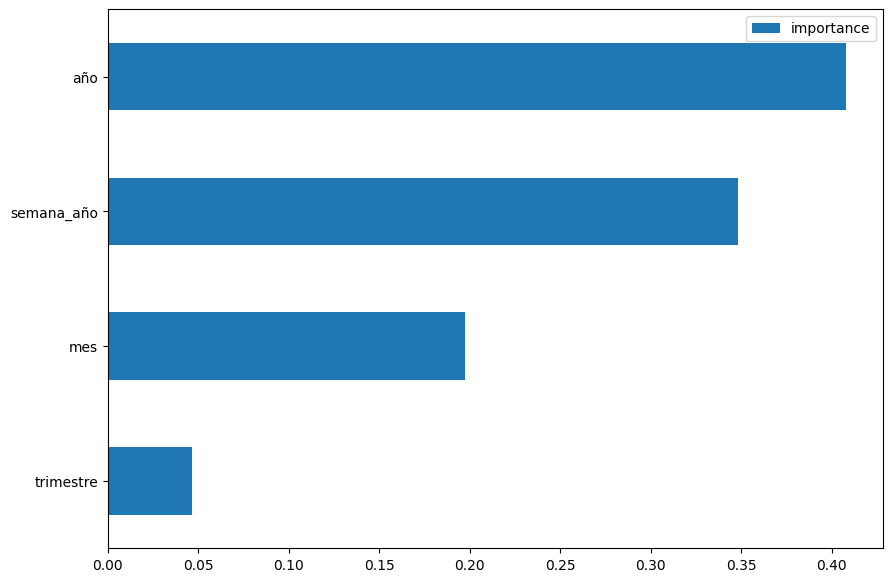

In [37]:
fit = pd.DataFrame(data = reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fig, ax = plt.subplots(figsize=(10, 7))
fit.sort_values('importance').plot(kind='barh', ax=ax)

### 3.2 Validación del modelo. Caso particular: demarcación del Duero.

Una vez se ha entrenado el modelo y se ha entendido su funcionamiento, se genera una nueva columna con las predicciones del valor de volumen_actual y esta se añade a la tabla de datos inicial. Esto es muy útil para comparar los valores y sobre todo, para comprobar la precisión del modelo, tanto visual como estadísticamente.

In [38]:
test_duero['prediccion']= reg.predict(X_test)

df_Duero = df_Duero.merge(test_duero[['prediccion']], how="left", left_index=True, right_index=True)

<ipython-input-38-291a8397b1f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_duero['prediccion']= reg.predict(X_test)


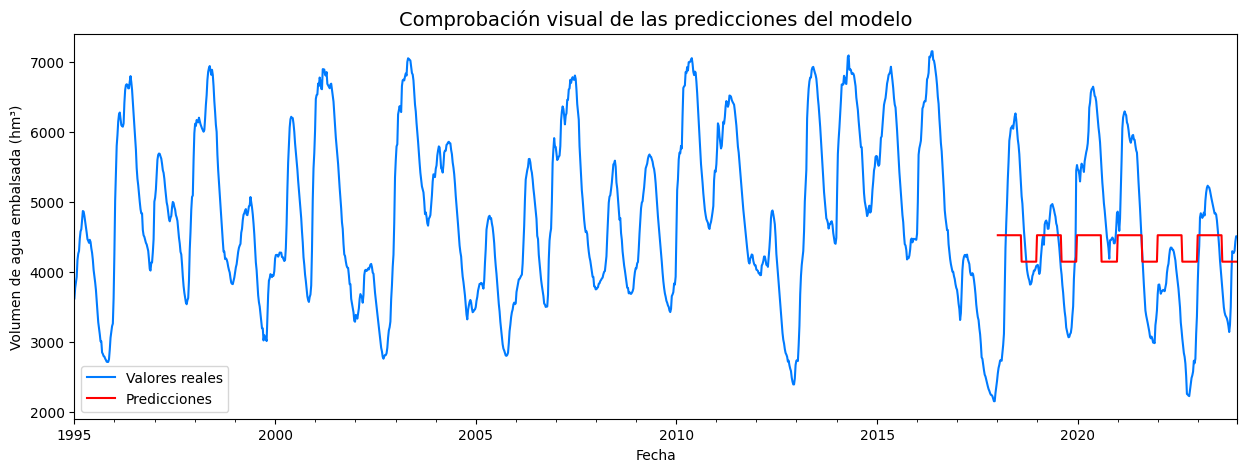

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))

df_Duero.plot(ax=ax, x='fecha', y='volumen_actual', label='Valores reales', color='#007bff')
df_Duero.plot(ax=ax, x='fecha', y='prediccion', label='Predicciones', color='#FF0000')

# Añadir título y etiquetas
plt.title('Comprobación visual de las predicciones del modelo', fontsize=14)
plt.xlabel('Fecha', fontsize=10)
plt.ylabel('Volumen de agua embalsada (hm³)', fontsize=10)
plt.legend()

plt.show()

### Segunda iteración para la mejora del modelo

* Se observa como debido a la importancia que da el modelo al año, tenemos unas predicciones que son completamente incorrectas, ya que como puede observarse en la figura anterior, el modelo no se ajusta en absoluto a la distribución de nuestros datos.
* Para evitar este problema, vamos a entrenar el modelo de nuevo, pero **eliminando el año como feature**, para comprobar su funcionamiento.

In [40]:
features = ['trimestre', 'mes', 'semana_año']
target = 'volumen_actual'

In [41]:
X_train = train_duero[features]
y_train = train_duero[target]

X_test = test_duero[features]
y_test = test_duero[target]

In [42]:
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<Axes: >

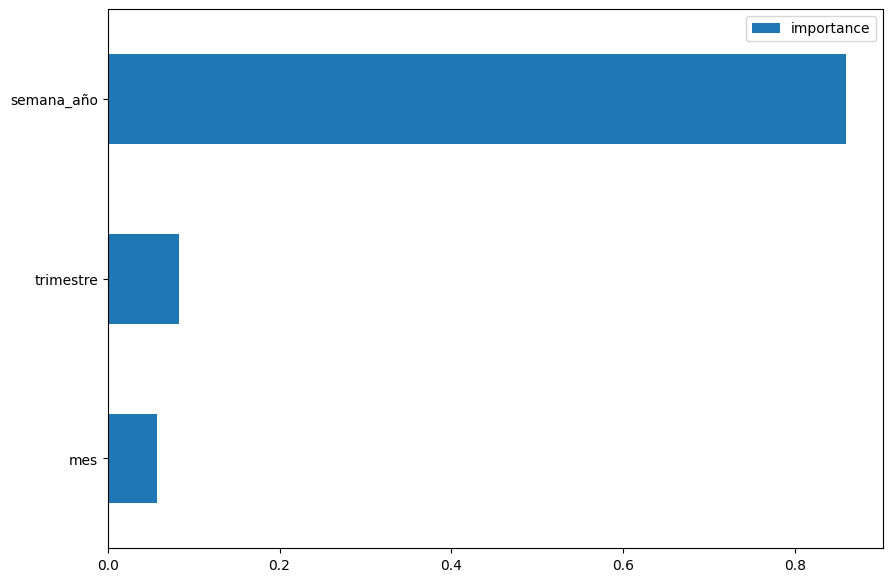

In [43]:
fit = pd.DataFrame(data = reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fig, ax = plt.subplots(figsize=(10, 7))
fit.sort_values('importance').plot(kind='barh', ax=ax)

In [44]:
test_duero['prediccion']= reg.predict(X_test)

df_Duero = df_Duero.merge(test_duero[['prediccion']], how="left", left_index=True, right_index=True)

<ipython-input-44-291a8397b1f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_duero['prediccion']= reg.predict(X_test)


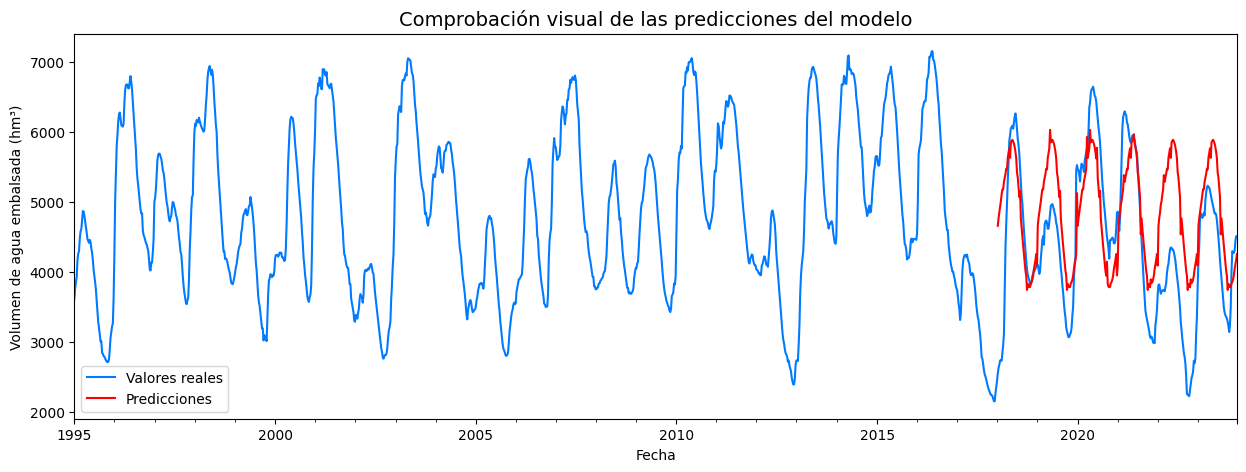

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))

df_Duero.plot(ax=ax, x='fecha', y='volumen_actual', label='Valores reales', color='#007bff')
df_Duero.plot(ax=ax, x='fecha', y='prediccion_y', label='Predicciones', color='#FF0000')

# Añadir título y etiquetas
plt.title('Comprobación visual de las predicciones del modelo', fontsize=14)
plt.xlabel('Fecha', fontsize=10)
plt.ylabel('Volumen de agua embalsada (hm³)', fontsize=10)
plt.legend()

plt.show()

Usamos la métrica del error porcentual absoluto medio (MAPE - Mean Absolute Percentage Error) para evaluar el funcionamiento del modelo de forma numérica.

In [46]:
test_duero["porcentaje"]= (abs(test_duero['prediccion'] - test_duero['volumen_actual'])/test_duero['volumen_actual']) * 100

<ipython-input-46-828da659b976>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_duero["porcentaje"]= (abs(test_duero['prediccion'] - test_duero['volumen_actual'])/test_duero['volumen_actual']) * 100


In [47]:
test_duero["porcentaje"].mean()

19.46313711566067

In [48]:
df_Duero.tail()

fecha  volumen_actual   año  trimestre  mes  semana_año  \
1508 2023-11-28          4272.0  2023          4   11          48   
1509 2023-12-05          4303.0  2023          4   12          49   
1510 2023-12-12          4436.0  2023          4   12          50   
1511 2023-12-19          4510.0  2023          4   12          51   
1512 2023-12-26          4508.0  2023          4   12          52   

      prediccion_x  prediccion_y  
1508   4146.418457   3946.270752  
1509   4146.418457   4041.904297  
1510   4146.418457   4108.854492  
1511   4146.418457   4167.870605  
1512   4146.418457   4254.406738

In [49]:
df_Duero.drop("prediccion_x", axis = 1, inplace = True)

In [50]:
df_Duero.rename({"prediccion_y":"prediccion"}, inplace = True)

### 3.3 Prediccion valores futuros. Caso particular: demarcación del Duero.

Re-entrenamos el modelo, pero esta vez con todos los datos, ya que hemos validado anteriormente que nuestro modelo era correcto

In [51]:
df_Duero.tail()

fecha  volumen_actual   año  trimestre  mes  semana_año  \
1508 2023-11-28          4272.0  2023          4   11          48   
1509 2023-12-05          4303.0  2023          4   12          49   
1510 2023-12-12          4436.0  2023          4   12          50   
1511 2023-12-19          4510.0  2023          4   12          51   
1512 2023-12-26          4508.0  2023          4   12          52   

      prediccion_y  
1508   3946.270752  
1509   4041.904297  
1510   4108.854492  
1511   4167.870605  
1512   4254.406738

In [52]:
df_Duero_all = df_Duero.drop("prediccion_y", axis = 1)

In [53]:
df_Duero_all.tail()

fecha  volumen_actual   año  trimestre  mes  semana_año
1508 2023-11-28          4272.0  2023          4   11          48
1509 2023-12-05          4303.0  2023          4   12          49
1510 2023-12-12          4436.0  2023          4   12          50
1511 2023-12-19          4510.0  2023          4   12          51
1512 2023-12-26          4508.0  2023          4   12          52

In [54]:
features = ['trimestre', 'mes', 'semana_año']
target = 'volumen_actual'

In [55]:
X_all = df_Duero_all[features]
y_all = df_Duero_all[target]

In [56]:
reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Generamos las predicciones de volumen de agua embalsada para los años 2024, 2025 y 2026, añadiendolas a la tabla de datos con los valores reales.

In [57]:
future = pd.date_range('2024-01-01', '2025-12-30')
tuesdays = future[future.weekday == 1] # Cogemos solo los martes, que es cuando se registran los niveles de los embalses
df_future = pd.DataFrame(index=tuesdays)

In [58]:
df_future.head()

Empty DataFrame
Columns: []
Index: [2024-01-02 00:00:00, 2024-01-09 00:00:00, 2024-01-16 00:00:00, 2024-01-23 00:00:00, 2024-01-30 00:00:00]

In [59]:
df_future.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2024-01-02 to 2025-12-30
Empty DataFrame


In [60]:
df_future['trimestre'] = df_future.index.quarter
df_future["mes"] = df_future.index.month
df_future['semana_año'] = df_future.index.isocalendar().week

In [61]:
df_future["fecha"] = df_future.index

In [62]:
df_final = pd.concat([df_Duero_all, df_future])

In [63]:
# Generamos las predicciones para el año 2024 y las añadimos a la tabla de datos iniciales.
df_future['prediccion']= reg.predict(df_future[features])
df_final = df_final.merge(df_future[['prediccion']], how="left", left_index=True, right_index=True)

In [64]:
df_final.tail()

fecha  volumen_actual  año  trimestre  mes  \
2025-12-02 00:00:00 2025-12-02             NaN  NaN          4   12   
2025-12-09 00:00:00 2025-12-09             NaN  NaN          4   12   
2025-12-16 00:00:00 2025-12-16             NaN  NaN          4   12   
2025-12-23 00:00:00 2025-12-23             NaN  NaN          4   12   
2025-12-30 00:00:00 2025-12-30             NaN  NaN          4   12   

                     semana_año   prediccion  
2025-12-02 00:00:00          49  3973.535156  
2025-12-09 00:00:00          50  4050.275635  
2025-12-16 00:00:00          51  4122.103027  
2025-12-23 00:00:00          52  4253.447754  
2025-12-30 00:00:00           1  5176.749512

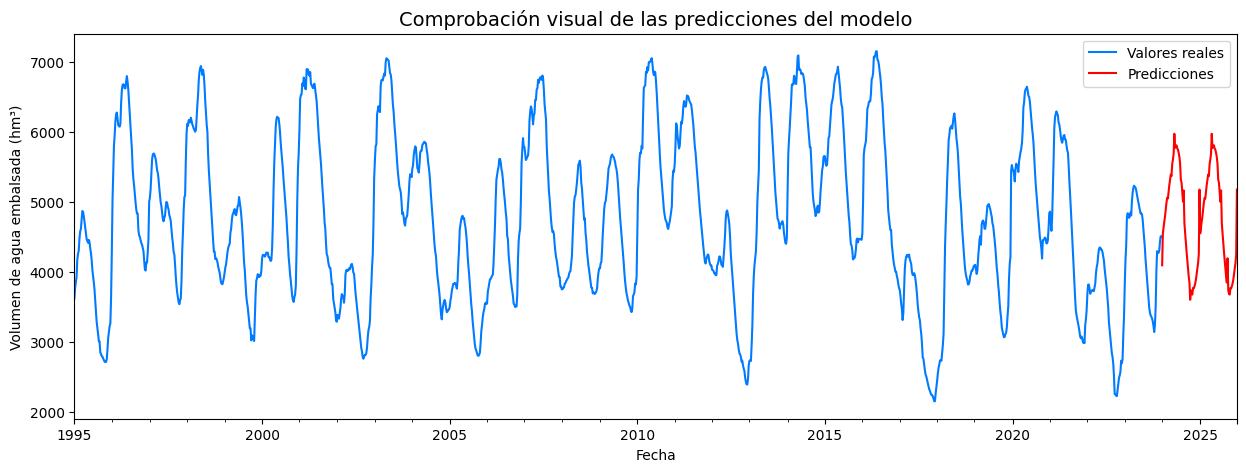

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))

df_final.plot(ax=ax, x='fecha', y='volumen_actual', label='Valores reales', color='#007bff')
df_final.plot(ax=ax, x='fecha', y='prediccion', label='Predicciones', color='#FF0000')

# Añadir título y etiquetas
plt.title('Comprobación visual de las predicciones del modelo', fontsize=14)
plt.xlabel('Fecha', fontsize=10)
plt.ylabel('Volumen de agua embalsada (hm³)', fontsize=10)
plt.legend()

plt.show()

## 4.Conclusiones obtenidas

* Una de las principales conclusiones que se extraen de este análisis predictivo es que el **modelo se sobreajusta a la media**. Como se puede observar en la visualización anterior, las predicciones sí recogen la estacionalidad del volumen embalsado, sin embargo, no se ajustan correctamente a los extremos, lo que nos indica que el modelo es ineficiente a la hora de tomar valores extremos. La **causa principal** de este error se debe a la **inexistencia de atributos suficientes para caracterizar correctamente el modelo**.
* El modelo, para poder tener una mayor exactitud y adaptarse mejor a las curvas de agua embalsada, debería contar con más atributos (estos datos no se han podido incluir en el modelo porque no se cumpliría con el tiempo de dedicación de este proyecto, por lo que se porpone como mejora del mismo para realizar en un futuro), los cuales podrían ser:
  * **Incluir datos de pluviometría y cuencas hidrográficas**: se podrían recoger los datos de lluvia a través de la red de pluviometros con la que cuenta España. Estos pluviometros se localizan en puntos estratégicos y ayudan en la toma de mediciones de cantidad de lluvia. Además, conocemos la posición exacta de dichos pluviómetros por lo que, junto con la información de las cuencas hidrográficas existentes en España, se podría realizar un análisis más exhaustivo y mejorar la precisión de nuestro modelo.
  * **Incluir datos de temperatura y horas de sol**: en este caso, podríamos recoger las temperaturas y horas promedio de sol para cada una de las localizaciones del embalse. Con esto, junto con la superfície del embalse, podríamos considerar el efecto que tiene la evaporación sobre los nieveles de los embalses.
* El **modelo es demasiado simple**. Se han sumado todos los datos de los embalses para cada demarcación hidrográfica con el objetivo de reducir la complejidad del modelo. Sin embargo, al hacer esto, se ha simplificado demasiado el modelo, ya que dentro de una misma cuenca hidrográfica se pueden dar condiciones muy diferentes en función del emblase que se analiza. Habría que realizar un modelo predictivo para cada embalse para así estudiar específicamente las condiciones de cada uno (este objetivo no se puede cumplir con el tiempo de dedicación de este proyecto, por lo que se porpone como mejora del mismo para realizar en un futuro).